In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## noncyclic Stocks

### Kweichow Moutai Co.,Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [8]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
X.shape

(4101, 20, 4)

In [9]:
v = X.reshape(X.shape[0],20, 4)
v[0]

array([[0.54516119, 0.84600903, 0.57981401, 0.44602313],
       [0.67741906, 0.81764258, 0.47008743, 0.63581435],
       [0.52903222, 0.71566271, 0.21778202, 0.4135914 ],
       [0.66129086, 0.69887415, 0.37329596, 0.68007334],
       [0.87741813, 0.79824363, 0.62742534, 0.89404847],
       [0.77741821, 0.82977539, 0.50984222, 0.6176701 ],
       [0.59999954, 0.76322236, 0.30122766, 0.42276134],
       [0.59677421, 0.70521334, 0.31912416, 0.32212253],
       [0.65483788, 0.68664132, 0.48045404, 0.40841106],
       [0.60645097, 0.64549915, 0.51372903, 0.28581551],
       [0.80645159, 0.71578715, 0.8676329 , 0.50294466],
       [0.93225802, 0.84137307, 1.        , 0.92563644],
       [0.76774144, 0.86118438, 0.6874353 , 0.76356529],
       [1.        , 1.        , 0.95097093, 1.        ],
       [0.61290395, 0.91403985, 0.25229917, 0.56592444],
       [0.50000039, 0.78197336, 0.04851892, 0.26150864],
       [0.58064446, 0.71260337, 0.5611309 , 0.75648321],
       [0.35483888, 0.53524454,

In [10]:
y = labels
y = np.array(y)
y.shape

(4101,)

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [13]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
26/26 [==============================] - 1s 34ms/step - loss: 0.2990 - accuracy: 0.5814 - mse: 0.4133 - weighted_accuracy: 0.3253 - weighted_mse: 0.5155 - val_loss: 0.3005 - val_accuracy: 0.0487 - val_mse: 0.3519 - val_weighted_accuracy: 0.0487 - val_weighted_mse: 0.3519
Epoch 2/200
26/26 [==============================] - 0s 8ms/step - loss: 0.2183 - accuracy: 0.4909 - mse: 0.6706 - weighted_accuracy: 0.4366 - weighted_mse: 0.7088 - val_loss: 0.2934 - val_accuracy: 0.0451 - val_mse: 0.3778 - val_weighted_accuracy: 0.0451 - val_weighted_mse: 0.3778
Epoch 3/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1953 - accuracy: 0.3518 - mse: 0.9120 - weighted_accuracy: 0.4827 - weighted_mse: 0.9042 - val_loss: 0.2849 - val_accuracy: 0.0451 - val_mse: 0.4146 - val_weighted_accuracy: 0.0451 - val_weighted_mse: 0.4146
Epoch 4/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1841 - accuracy: 0.3314 - mse: 1.0609 - weighted_accuracy: 0.5202 - weighte

Epoch 30/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1349 - accuracy: 0.4680 - mse: 1.5868 - weighted_accuracy: 0.7257 - weighted_mse: 1.5302 - val_loss: 0.2034 - val_accuracy: 0.3106 - val_mse: 1.5722 - val_weighted_accuracy: 0.3106 - val_weighted_mse: 1.5722
Epoch 31/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1341 - accuracy: 0.4165 - mse: 1.6409 - weighted_accuracy: 0.7196 - weighted_mse: 1.5563 - val_loss: 0.2021 - val_accuracy: 0.3094 - val_mse: 1.6188 - val_weighted_accuracy: 0.3094 - val_weighted_mse: 1.6188
Epoch 32/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1329 - accuracy: 0.4482 - mse: 1.6478 - weighted_accuracy: 0.7249 - weighted_mse: 1.5817 - val_loss: 0.1820 - val_accuracy: 0.4348 - val_mse: 1.6537 - val_weighted_accuracy: 0.4348 - val_weighted_mse: 1.6537
Epoch 33/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1320 - accuracy: 0.4741 - mse: 1.6428 - weighted_accuracy: 0.7408 - weig

Epoch 59/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1076 - accuracy: 0.6162 - mse: 2.1234 - weighted_accuracy: 0.8251 - weighted_mse: 2.1273 - val_loss: 0.1894 - val_accuracy: 0.4933 - val_mse: 2.1443 - val_weighted_accuracy: 0.4933 - val_weighted_mse: 2.1443
Epoch 60/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1055 - accuracy: 0.6064 - mse: 2.1350 - weighted_accuracy: 0.8322 - weighted_mse: 2.1243 - val_loss: 0.2030 - val_accuracy: 0.4519 - val_mse: 2.3984 - val_weighted_accuracy: 0.4519 - val_weighted_mse: 2.3984
Epoch 61/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1065 - accuracy: 0.6024 - mse: 2.1549 - weighted_accuracy: 0.8330 - weighted_mse: 2.1502 - val_loss: 0.1730 - val_accuracy: 0.5396 - val_mse: 2.2244 - val_weighted_accuracy: 0.5396 - val_weighted_mse: 2.2244
Epoch 62/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1033 - accuracy: 0.6433 - mse: 2.1452 - weighted_accuracy: 0.8371 - weig

Epoch 88/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0826 - accuracy: 0.7402 - mse: 2.8665 - weighted_accuracy: 0.8876 - weighted_mse: 2.9713 - val_loss: 0.1693 - val_accuracy: 0.6261 - val_mse: 3.0771 - val_weighted_accuracy: 0.6261 - val_weighted_mse: 3.0771
Epoch 89/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0825 - accuracy: 0.7430 - mse: 2.9259 - weighted_accuracy: 0.8930 - weighted_mse: 2.9722 - val_loss: 0.1552 - val_accuracy: 0.6687 - val_mse: 3.0896 - val_weighted_accuracy: 0.6687 - val_weighted_mse: 3.0896
Epoch 90/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0809 - accuracy: 0.7402 - mse: 2.9023 - weighted_accuracy: 0.8963 - weighted_mse: 2.9607 - val_loss: 0.1862 - val_accuracy: 0.5895 - val_mse: 3.0999 - val_weighted_accuracy: 0.5895 - val_weighted_mse: 3.0999
Epoch 91/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0813 - accuracy: 0.7360 - mse: 2.9635 - weighted_accuracy: 0.8905 - weig

Epoch 117/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0648 - accuracy: 0.8037 - mse: 4.0264 - weighted_accuracy: 0.9217 - weighted_mse: 4.1080 - val_loss: 0.2039 - val_accuracy: 0.6151 - val_mse: 4.1298 - val_weighted_accuracy: 0.6151 - val_weighted_mse: 4.1298
Epoch 118/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0613 - accuracy: 0.8095 - mse: 4.0790 - weighted_accuracy: 0.9302 - weighted_mse: 4.1462 - val_loss: 0.1694 - val_accuracy: 0.6943 - val_mse: 4.5589 - val_weighted_accuracy: 0.6943 - val_weighted_mse: 4.5589
Epoch 119/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0600 - accuracy: 0.8216 - mse: 4.1057 - weighted_accuracy: 0.9261 - weighted_mse: 4.1868 - val_loss: 0.1781 - val_accuracy: 0.6833 - val_mse: 4.1825 - val_weighted_accuracy: 0.6833 - val_weighted_mse: 4.1825
Epoch 120/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0604 - accuracy: 0.8250 - mse: 4.1522 - weighted_accuracy: 0.9273 - 

Epoch 146/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0456 - accuracy: 0.8637 - mse: 5.5946 - weighted_accuracy: 0.9458 - weighted_mse: 5.5027 - val_loss: 0.1826 - val_accuracy: 0.7320 - val_mse: 6.6688 - val_weighted_accuracy: 0.7320 - val_weighted_mse: 6.6688
Epoch 147/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0466 - accuracy: 0.8671 - mse: 5.5969 - weighted_accuracy: 0.9513 - weighted_mse: 5.4534 - val_loss: 0.1758 - val_accuracy: 0.7174 - val_mse: 5.9338 - val_weighted_accuracy: 0.7174 - val_weighted_mse: 5.9338
Epoch 148/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0456 - accuracy: 0.8747 - mse: 5.7130 - weighted_accuracy: 0.9498 - weighted_mse: 5.5892 - val_loss: 0.1984 - val_accuracy: 0.6882 - val_mse: 6.0407 - val_weighted_accuracy: 0.6882 - val_weighted_mse: 6.0407
Epoch 149/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0449 - accuracy: 0.8646 - mse: 5.6590 - weighted_accuracy: 0.9462 - 

Epoch 175/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0349 - accuracy: 0.9058 - mse: 7.3521 - weighted_accuracy: 0.9633 - weighted_mse: 6.9633 - val_loss: 0.2132 - val_accuracy: 0.7320 - val_mse: 8.2643 - val_weighted_accuracy: 0.7320 - val_weighted_mse: 8.2643
Epoch 176/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0349 - accuracy: 0.9073 - mse: 7.2968 - weighted_accuracy: 0.9661 - weighted_mse: 6.8274 - val_loss: 0.2138 - val_accuracy: 0.7442 - val_mse: 7.6050 - val_weighted_accuracy: 0.7442 - val_weighted_mse: 7.6050
Epoch 177/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0332 - accuracy: 0.9034 - mse: 7.3599 - weighted_accuracy: 0.9646 - weighted_mse: 6.9869 - val_loss: 0.1950 - val_accuracy: 0.7674 - val_mse: 8.1181 - val_weighted_accuracy: 0.7674 - val_weighted_mse: 8.1181
Epoch 178/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 0.9046 - mse: 7.4609 - weighted_accuracy: 0.9629 - 

In [17]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23476362228393555
Test accuracy: 0.7637028098106384


In [18]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.7575592  -4.3283467  -0.03887925]
 [-2.8374288  -3.3972914   1.6779833 ]
 [-1.6589779  -2.8058913   0.86115843]
 ...
 [-1.9158368  -4.7322483   1.0799896 ]
 [-3.3363917  -4.6343274   2.4988334 ]
 [-1.7342948  -2.8838532   0.71618724]]


Counter({2: 696, 0: 68, 1: 57})

In [19]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 747, 1: 37, 0: 37})

In [20]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 821
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 34
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 37
actual holds but predicted buy: 55
actual holds but predicted sell: 67
actual predicted holds: 625
Percentage buys correct: 5.405405405405405%
Percentage sells correct: 0.0%
Percentage holds correct: 83.66800535475234%
actual buys: 37
actual sells: 37
actual holds: 747


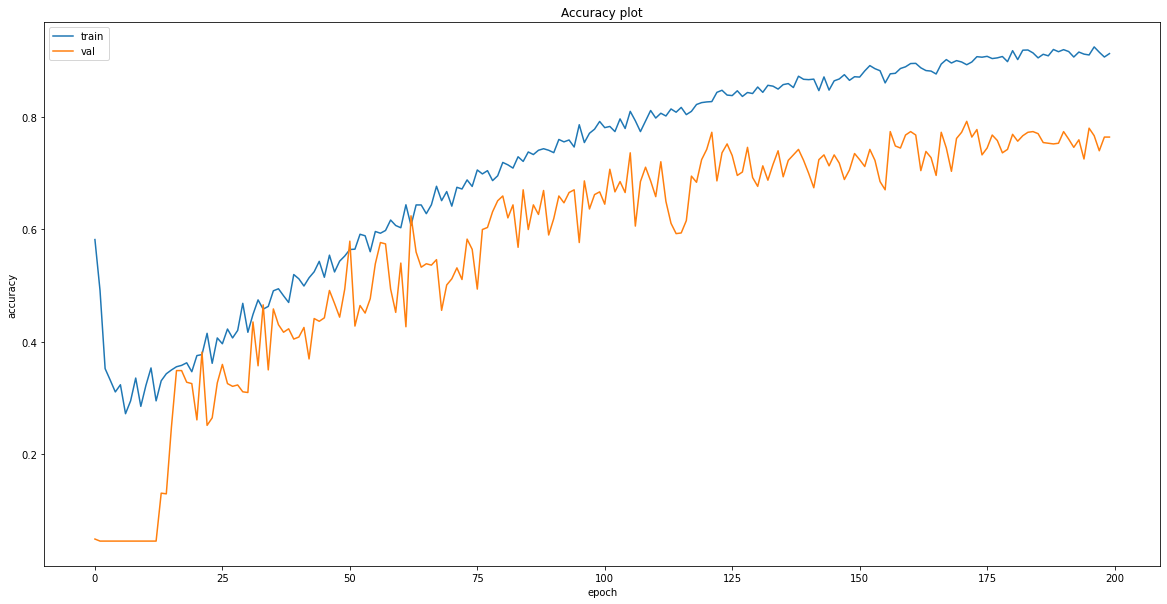

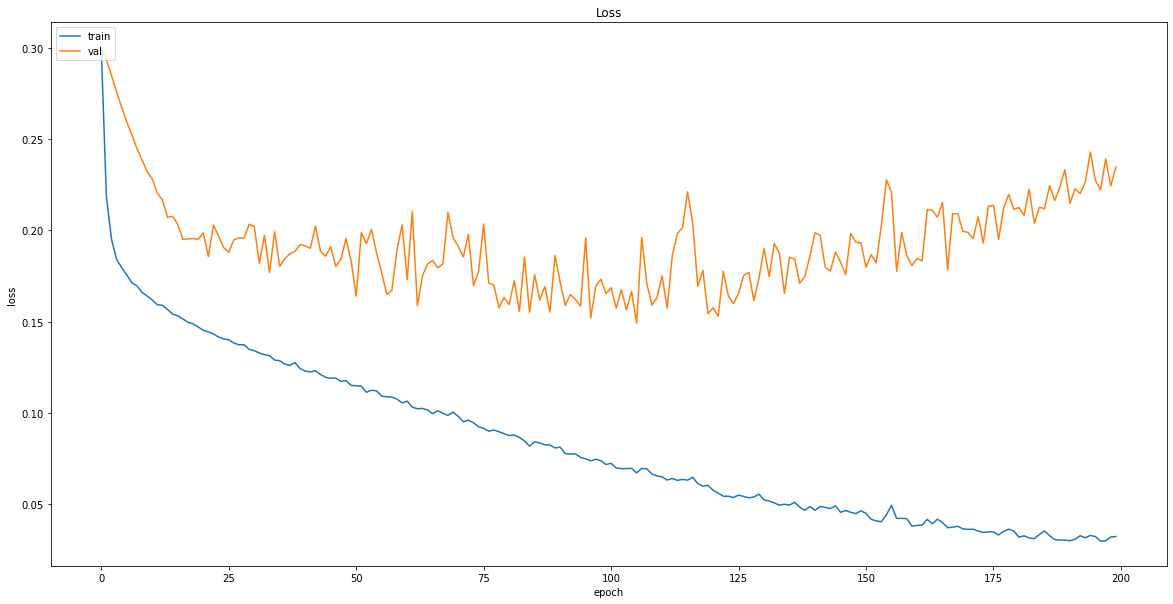

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
# Save model
model.save("models/{}".format('moutai_time_series_lstm_buy_hold_sell_20.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_time_series_lstm_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [23]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-13,589.000000,582.108121,-38.732394,1.228418e+09,2.0
2018-12-14,601.750000,585.129949,-20.774648,1.232458e+09,2.0
2018-12-17,592.960022,586.334575,-33.154899,1.230002e+09,2.0
2018-12-18,590.520020,586.978490,-36.591522,1.227513e+09,2.0
2018-12-19,590.940002,587.587953,-37.872279,1.229435e+09,2.0


In [24]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [25]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(207, 20, 4)

In [26]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [27]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2457 - accuracy: 0.7729 - mean_squared_error: 10.4101 - weighted_accuracy: 0.7729 - weighted_mean_squared_error: 10.4101
Test loss: 0.2456577867269516
Test accuracy: 0.772946834564209


In [28]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 24, 2: 175, 1: 8})

In [29]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [30]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-30-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-30-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-30-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,740.00000,704.389763,-23.444619,43919901.0,2.0,0,2
2019-02-19,730.76001,709.868261,-6.049880,47694490.0,2.0,0,2
2019-02-20,722.00000,713.082376,-17.677836,44744340.0,2.0,0,2
2019-02-21,720.25000,714.454318,-29.824573,40956103.0,2.0,2,2
2019-02-22,726.01001,715.345962,-32.098776,37971063.0,2.0,2,2


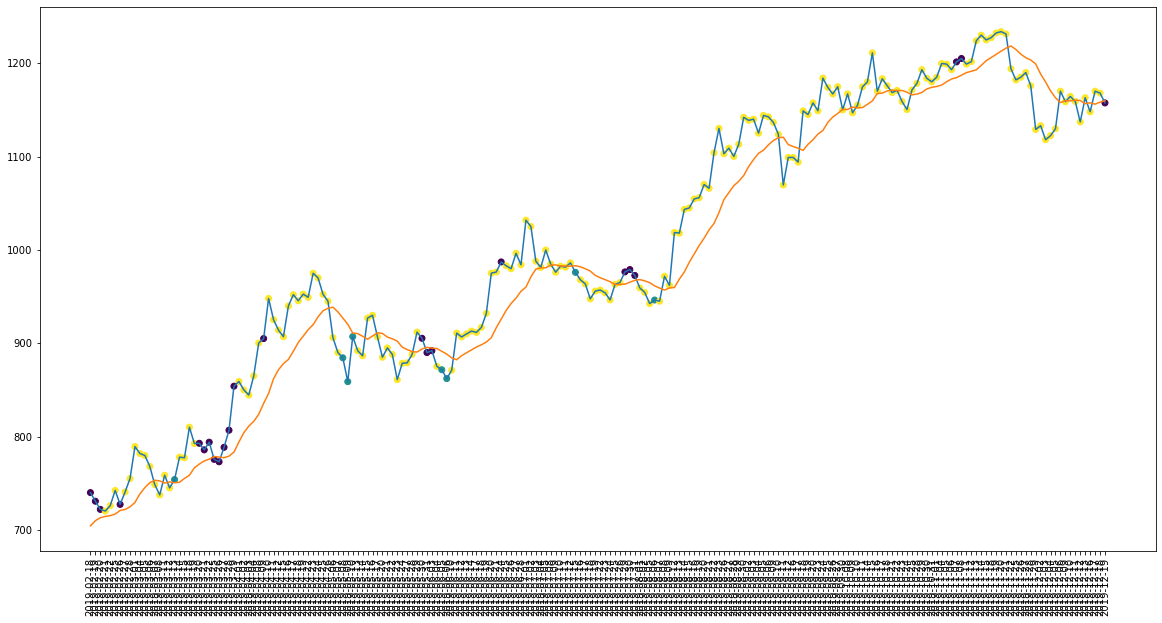

In [31]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [32]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 6
actual holds but predicted sell: 22
actual predicted holds: 157
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 84.86486486486487%
actual buys: 11
actual sells: 11
actual holds: 185


In [33]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 75.0%
Percentage sells correct: 60.869565217391305%
Percentage holds correct: 85.14285714285714%


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 75.0%
Percentage sells correct: 60.869565217391305%
Percentage holds correct: 85.14285714285714%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $754.0
Shares owned at the moment: 13
Cash capital at the moment: $171.04449999999997


Price increase from previously bought: 5.01624511373564%
Share price: $794.0
Shares owned at the moment: 0
Cash capital at the moment: $10464.659


Share price: $884.4000244140625
Shares owned at the moment: 11
Cash capital at the moment: $709.5056307067862


Stop Loss Activated!

Share price: $858.8099975585938
Shares owned at the moment: 0
Cash capital at the moment: $10130.43660142517


Share price: $858.8099975585938
Shares owned at the moment: 11
Cash capital at the moment: $657.5476258544913


Price increase from previously bought: 5.1242117521253405%
Share price: $905.2999877929688
Shares owned at the moment: 0
Cash capital at the moment: $10588.46216694641


Share price: $871.5999755859375
Shares owned at the moment: 12
Cash capital at the moment: $100.49966072082498


Price increase from previously bought: 12.940904393966113%
Share price: $987.0999755859376
Shares owned at the 

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


### Recession

In [37]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-16,1163.000000,1157.540407,-41.535401,54780462.0,2.0
2019-12-17,1147.920044,1156.060351,-58.603130,51686820.0,2.0
2019-12-18,1169.979980,1158.201833,-32.533716,55948516.0,2.0
2019-12-19,1168.000000,1159.709243,-12.676282,53984507.0,2.0
2019-12-20,1157.400024,1159.353979,-31.925802,52029277.0,2.0


In [38]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [39]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(208, 20, 4)

In [40]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [41]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1834 - accuracy: 0.8558 - mean_squared_error: 10.1764 - weighted_accuracy: 0.8558 - weighted_mean_squared_error: 10.1764
Test loss: 0.18343082070350647
Test accuracy: 0.8557692170143127


In [42]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 193, 0: 11, 1: 4})

In [43]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [44]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-44-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-44-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-44-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


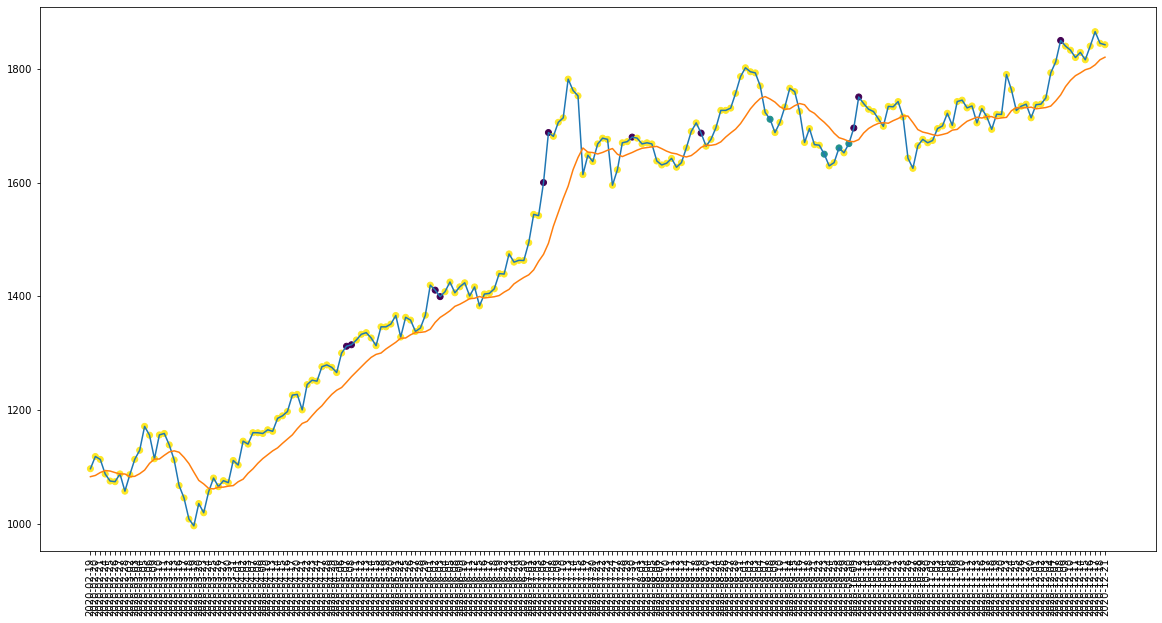

In [45]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [46]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 4
actual holds but predicted sell: 9
actual predicted holds: 176
Percentage buys correct: 0.0%
Percentage sells correct: 20.0%
Percentage holds correct: 93.12169312169313%
actual buys: 9
actual sells: 10
actual holds: 189


In [47]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 50.0%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 85.41666666666667%


In [48]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1711.4000244140625
Shares owned at the moment: 5
Cash capital at the moment: $1419.4681275939947


Stop Loss Activated!

Share price: $1649.97998046875
Shares owned at the moment: 0
Cash capital at the moment: $9646.680805206299


Share price: $1649.97998046875
Shares owned at the moment: 5
Cash capital at the moment: $1374.093678131103


Price increase from previously bought: 5.807890473708266%
Share price: $1750.6099853515625
Shares owned at the moment: 0
Cash capital at the moment: $10103.07271759033




Capital at the end of test period: $10103.07271759033
profit gained: 1.030727175903303%


In [49]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


### Midea Group

In [50]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


In [51]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [52]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [53]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
X.shape

(1248, 20, 4)

In [54]:
y = labels
y = np.array(y)

In [55]:
X[0]

array([[1.07912327e-02, 7.57565463e-04, 6.42210913e-01, 1.30903981e-01],
       [0.00000000e+00, 0.00000000e+00, 5.85071320e-01, 0.00000000e+00],
       [2.51798432e-01, 6.69788361e-02, 7.53849907e-01, 2.45674462e-01],
       [5.82734285e-01, 2.12525250e-01, 9.75021627e-01, 5.65489346e-01],
       [5.05395938e-01, 3.14910884e-01, 8.53996393e-01, 3.71827107e-01],
       [2.66186527e-01, 3.37305780e-01, 5.67962778e-01, 1.66040520e-01],
       [5.19784034e-01, 4.24358297e-01, 6.73381318e-01, 4.54090091e-01],
       [5.55755882e-01, 5.07678271e-01, 7.05898866e-01, 6.95347478e-01],
       [8.74101427e-01, 6.63670705e-01, 1.00000000e+00, 9.41629043e-01],
       [7.76979047e-01, 7.69582326e-01, 8.83748189e-01, 7.14070453e-01],
       [1.00000000e+00, 9.19091582e-01, 9.45611084e-01, 1.00000000e+00],
       [6.81654454e-01, 9.60108497e-01, 6.44675787e-01, 7.62522573e-01],
       [5.66547114e-01, 9.63903322e-01, 5.43316376e-01, 5.92648040e-01],
       [6.07913614e-01, 9.78223201e-01, 5.79742238e

In [56]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [57]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [58]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [60]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 0 2 2 2 2 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2
 1 0 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 1 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2
 2 2 2 2 1 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 0
 2 2 2 0 0 1 2 2 2 2 2 2 2 0 2 2 1 1 2 1 2 2 0 2 0 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 1 2 2 2 2 2 

Epoch 1/200
8/8 [==============================] - 1s 88ms/step - loss: 0.3437 - accuracy: 0.5802 - mse: 0.3429 - weighted_accuracy: 0.2923 - weighted_mse: 0.4559 - val_loss: 0.3032 - val_accuracy: 0.0440 - val_mse: 0.3396 - val_weighted_accuracy: 0.0440 - val_weighted_mse: 0.3396
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2837 - accuracy: 0.5621 - mse: 0.4090 - weighted_accuracy: 0.3674 - weighted_mse: 0.4805 - val_loss: 0.3030 - val_accuracy: 0.0560 - val_mse: 0.3457 - val_weighted_accuracy: 0.0560 - val_weighted_mse: 0.3457
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2491 - accuracy: 0.5200 - mse: 0.4914 - weighted_accuracy: 0.4178 - weighted_mse: 0.5324 - val_loss: 0.3012 - val_accuracy: 0.0480 - val_mse: 0.3500 - val_weighted_accuracy: 0.0480 - val_weighted_mse: 0.3500
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.2274 - accuracy: 0.4739 - mse: 0.5810 - weighted_accuracy: 0.4494 - weighted_mse:

8/8 [==============================] - 0s 8ms/step - loss: 0.1363 - accuracy: 0.5060 - mse: 1.3076 - weighted_accuracy: 0.7617 - weighted_mse: 1.2598 - val_loss: 0.2273 - val_accuracy: 0.0480 - val_mse: 0.7160 - val_weighted_accuracy: 0.0480 - val_weighted_mse: 0.7160
Epoch 31/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1354 - accuracy: 0.5100 - mse: 1.3150 - weighted_accuracy: 0.7631 - weighted_mse: 1.2735 - val_loss: 0.2258 - val_accuracy: 0.0480 - val_mse: 0.7327 - val_weighted_accuracy: 0.0480 - val_weighted_mse: 0.7327
Epoch 32/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1351 - accuracy: 0.4980 - mse: 1.3319 - weighted_accuracy: 0.7459 - weighted_mse: 1.2808 - val_loss: 0.2239 - val_accuracy: 0.0520 - val_mse: 0.7565 - val_weighted_accuracy: 0.0520 - val_weighted_mse: 0.7565
Epoch 33/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1348 - accuracy: 0.4970 - mse: 1.3372 - weighted_accuracy: 0.7584 - weighted_mse: 1.2774 - va

8/8 [==============================] - 0s 8ms/step - loss: 0.1070 - accuracy: 0.6283 - mse: 1.5375 - weighted_accuracy: 0.8432 - weighted_mse: 1.5137 - val_loss: 0.1846 - val_accuracy: 0.3680 - val_mse: 1.2437 - val_weighted_accuracy: 0.3680 - val_weighted_mse: 1.2437
Epoch 60/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1055 - accuracy: 0.6443 - mse: 1.5452 - weighted_accuracy: 0.8491 - weighted_mse: 1.5315 - val_loss: 0.1831 - val_accuracy: 0.3760 - val_mse: 1.2726 - val_weighted_accuracy: 0.3760 - val_weighted_mse: 1.2726
Epoch 61/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1051 - accuracy: 0.6413 - mse: 1.5598 - weighted_accuracy: 0.8544 - weighted_mse: 1.5655 - val_loss: 0.1838 - val_accuracy: 0.3880 - val_mse: 1.2699 - val_weighted_accuracy: 0.3880 - val_weighted_mse: 1.2699
Epoch 62/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1041 - accuracy: 0.6232 - mse: 1.5804 - weighted_accuracy: 0.8478 - weighted_mse: 1.5580 - va

8/8 [==============================] - 0s 8ms/step - loss: 0.0819 - accuracy: 0.7265 - mse: 1.9083 - weighted_accuracy: 0.8997 - weighted_mse: 1.9493 - val_loss: 0.1583 - val_accuracy: 0.6480 - val_mse: 1.7199 - val_weighted_accuracy: 0.6480 - val_weighted_mse: 1.7199
Epoch 89/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0822 - accuracy: 0.7475 - mse: 1.9060 - weighted_accuracy: 0.9074 - weighted_mse: 1.9490 - val_loss: 0.1586 - val_accuracy: 0.6320 - val_mse: 1.7962 - val_weighted_accuracy: 0.6320 - val_weighted_mse: 1.7962
Epoch 90/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0811 - accuracy: 0.7425 - mse: 1.9337 - weighted_accuracy: 0.9055 - weighted_mse: 1.9774 - val_loss: 0.1699 - val_accuracy: 0.5840 - val_mse: 1.9325 - val_weighted_accuracy: 0.5840 - val_weighted_mse: 1.9325
Epoch 91/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0794 - accuracy: 0.7425 - mse: 1.9518 - weighted_accuracy: 0.9055 - weighted_mse: 2.0128 - va

8/8 [==============================] - 0s 8ms/step - loss: 0.0606 - accuracy: 0.8257 - mse: 2.5166 - weighted_accuracy: 0.9361 - weighted_mse: 2.5782 - val_loss: 0.1602 - val_accuracy: 0.7240 - val_mse: 2.7974 - val_weighted_accuracy: 0.7240 - val_weighted_mse: 2.7974
Epoch 118/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0596 - accuracy: 0.8337 - mse: 2.5616 - weighted_accuracy: 0.9390 - weighted_mse: 2.6222 - val_loss: 0.1618 - val_accuracy: 0.7200 - val_mse: 2.8422 - val_weighted_accuracy: 0.7200 - val_weighted_mse: 2.8422
Epoch 119/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0598 - accuracy: 0.8257 - mse: 2.6208 - weighted_accuracy: 0.9361 - weighted_mse: 2.6800 - val_loss: 0.1695 - val_accuracy: 0.7040 - val_mse: 2.8338 - val_weighted_accuracy: 0.7040 - val_weighted_mse: 2.8338
Epoch 120/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0594 - accuracy: 0.8357 - mse: 2.6297 - weighted_accuracy: 0.9397 - weighted_mse: 2.6904 -

Epoch 146/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0443 - accuracy: 0.8888 - mse: 3.3634 - weighted_accuracy: 0.9592 - weighted_mse: 3.3405 - val_loss: 0.1770 - val_accuracy: 0.7720 - val_mse: 3.8350 - val_weighted_accuracy: 0.7720 - val_weighted_mse: 3.8350
Epoch 147/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0449 - accuracy: 0.8808 - mse: 3.3922 - weighted_accuracy: 0.9563 - weighted_mse: 3.3354 - val_loss: 0.1791 - val_accuracy: 0.7640 - val_mse: 3.8862 - val_weighted_accuracy: 0.7640 - val_weighted_mse: 3.8862
Epoch 148/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.8808 - mse: 3.4352 - weighted_accuracy: 0.9563 - weighted_mse: 3.4210 - val_loss: 0.2091 - val_accuracy: 0.7080 - val_mse: 3.8138 - val_weighted_accuracy: 0.7080 - val_weighted_mse: 3.8138
Epoch 149/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0446 - accuracy: 0.8778 - mse: 3.4785 - weighted_accuracy: 0.9552 - weighted

Epoch 175/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0348 - accuracy: 0.8948 - mse: 4.4277 - weighted_accuracy: 0.9614 - weighted_mse: 4.1515 - val_loss: 0.2319 - val_accuracy: 0.7080 - val_mse: 4.8977 - val_weighted_accuracy: 0.7080 - val_weighted_mse: 4.8977
Epoch 176/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0343 - accuracy: 0.8978 - mse: 4.4546 - weighted_accuracy: 0.9625 - weighted_mse: 4.1961 - val_loss: 0.2486 - val_accuracy: 0.6960 - val_mse: 4.9479 - val_weighted_accuracy: 0.6960 - val_weighted_mse: 4.9479
Epoch 177/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0328 - accuracy: 0.9148 - mse: 4.4854 - weighted_accuracy: 0.9688 - weighted_mse: 4.1870 - val_loss: 0.2271 - val_accuracy: 0.7280 - val_mse: 4.9975 - val_weighted_accuracy: 0.7280 - val_weighted_mse: 4.9975
Epoch 178/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0313 - accuracy: 0.9128 - mse: 4.5504 - weighted_accuracy: 0.9680 - weighted

In [61]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.25364258885383606
Test accuracy: 0.7319999933242798


In [62]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.4681865  -1.9866083  -0.7947057 ]
 [-2.882826   -1.9203236   1.8652681 ]
 [-2.74368    -1.9361622   1.1233498 ]
 [-3.8446887   0.06537469 -0.4187648 ]
 [-4.245426   -3.706642    2.5332894 ]
 [-1.7623811  -3.1378608   1.416252  ]
 [-3.6788635  -0.04461122 -0.93713605]
 [-1.0292879  -1.3581814  -0.9167227 ]
 [-1.4502393  -2.667405    0.41614288]
 [-3.4730966  -3.1938937   2.886487  ]
 [-3.6321926  -0.08180396 -0.14057986]
 [-4.0231714   2.0189693  -1.7227803 ]
 [-1.0430185  -2.1212435   0.08935808]
 [-2.6839762  -1.5495816   1.2038559 ]
 [-3.2884521  -0.72689235  0.2024485 ]
 [ 0.18139938 -3.8273237   0.45323023]
 [-4.553436    1.6246034  -2.4198747 ]
 [-1.2932851  -0.3817596  -1.3188782 ]
 [-4.0637665  -1.7563816   0.7520426 ]
 [-2.460602    0.94870037 -1.4644691 ]
 [-2.550199   -2.9874277   1.4765087 ]
 [-3.9906998  -2.560768    0.97761106]
 [-2.6884441  -3.320505    1.8273729 ]
 [-4.5624347  -1.0629705   0.8622803 ]
 [-1.4653491  -2.62597     0.29402208]
 [-3.3145382  -1.6700746 

Counter({0: 18, 2: 202, 1: 30})

In [63]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 227, 1: 13, 0: 10})

In [64]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 250
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 28
actual holds but predicted sell: 18
actual predicted holds: 181
Percentage buys correct: 15.384615384615385%
Percentage sells correct: 0.0%
Percentage holds correct: 79.73568281938326%
actual buys: 13
actual sells: 10
actual holds: 227


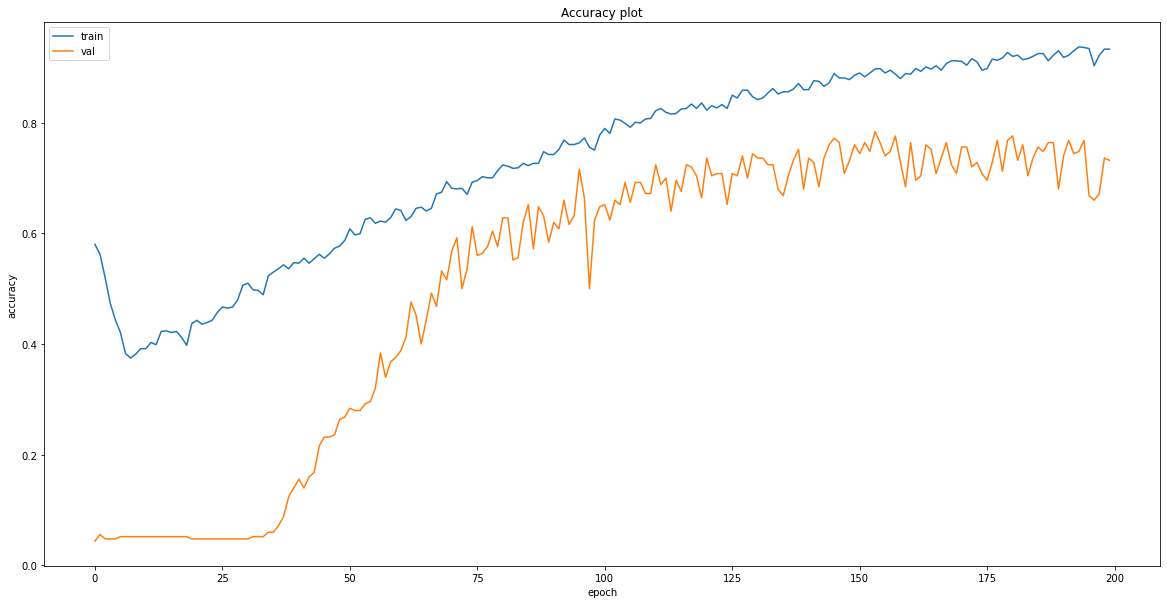

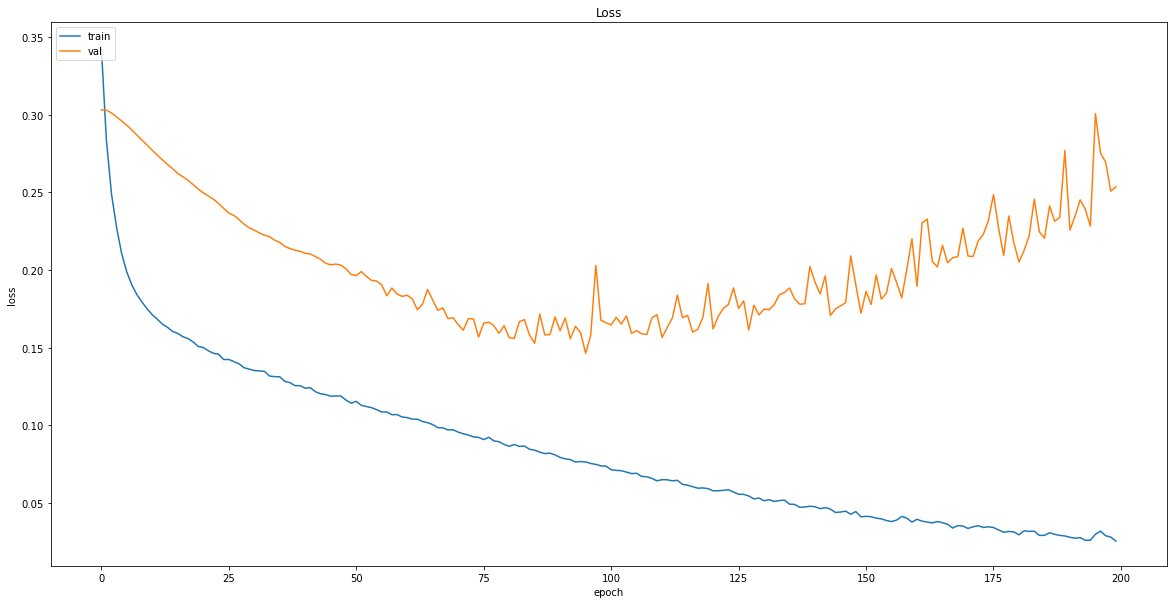

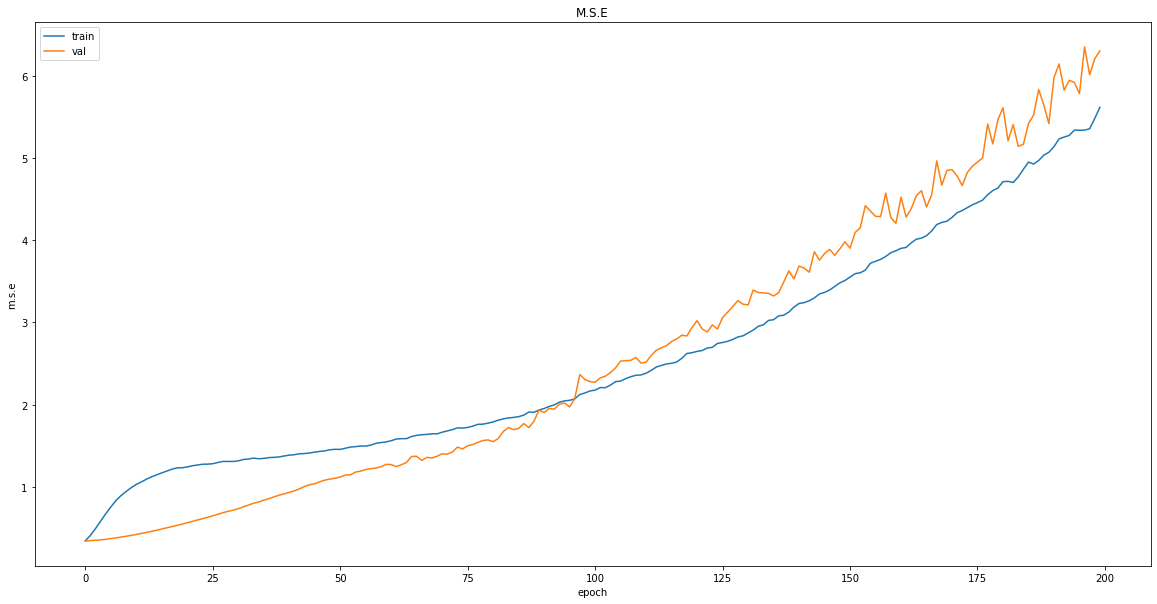

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [66]:
# Save model
model.save("models/{}".format('midea_time_series_lstm_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/midea_time_series_lstm_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [67]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-13,37.740002,38.759611,-71.929776,4.973847e+09,2.0
2018-12-14,40.119999,38.968901,-19.383280,5.047660e+09,2.0
2018-12-17,39.750000,39.089070,-27.533034,5.015177e+09,2.0
2018-12-18,39.459999,39.146136,-33.920718,4.984902e+09,2.0
2018-12-19,38.810001,39.094423,-48.237845,4.952096e+09,2.0


In [68]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [69]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(207, 20, 4)

In [70]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [71]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1747 - accuracy: 0.7633 - mean_squared_error: 5.2487 - weighted_accuracy: 0.7633 - weighted_mean_squared_error: 5.2487
Test loss: 0.17471836507320404
Test accuracy: 0.7632850408554077


In [72]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 169, 1: 22, 0: 16})

In [73]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [74]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-74-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-74-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-74-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,2,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,2,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,2,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,2,2


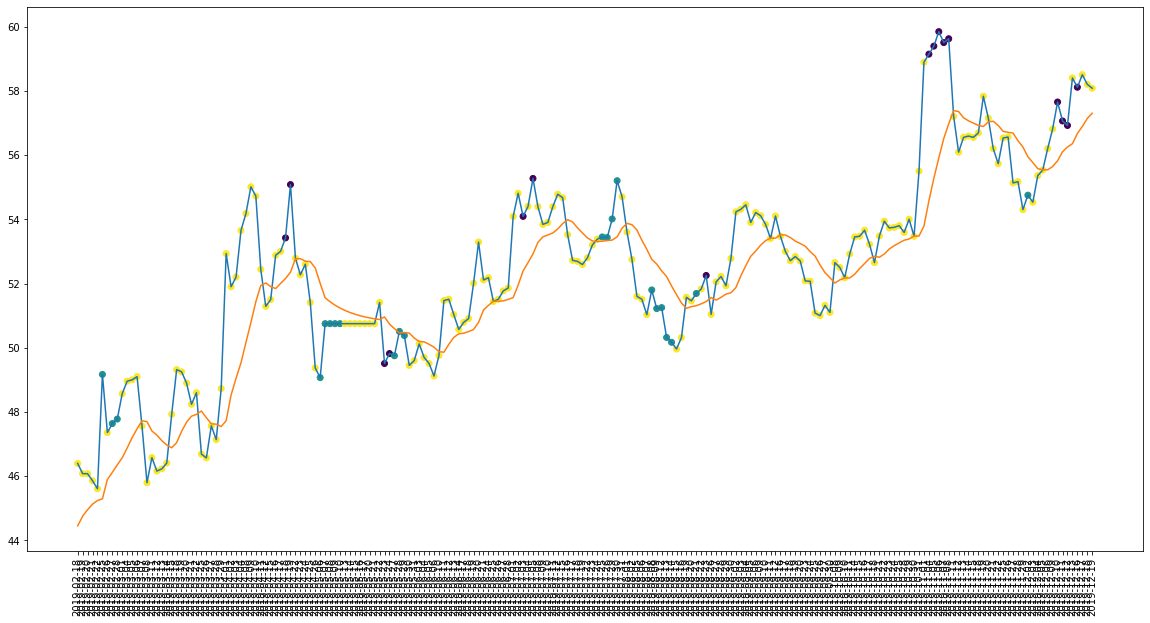

In [75]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

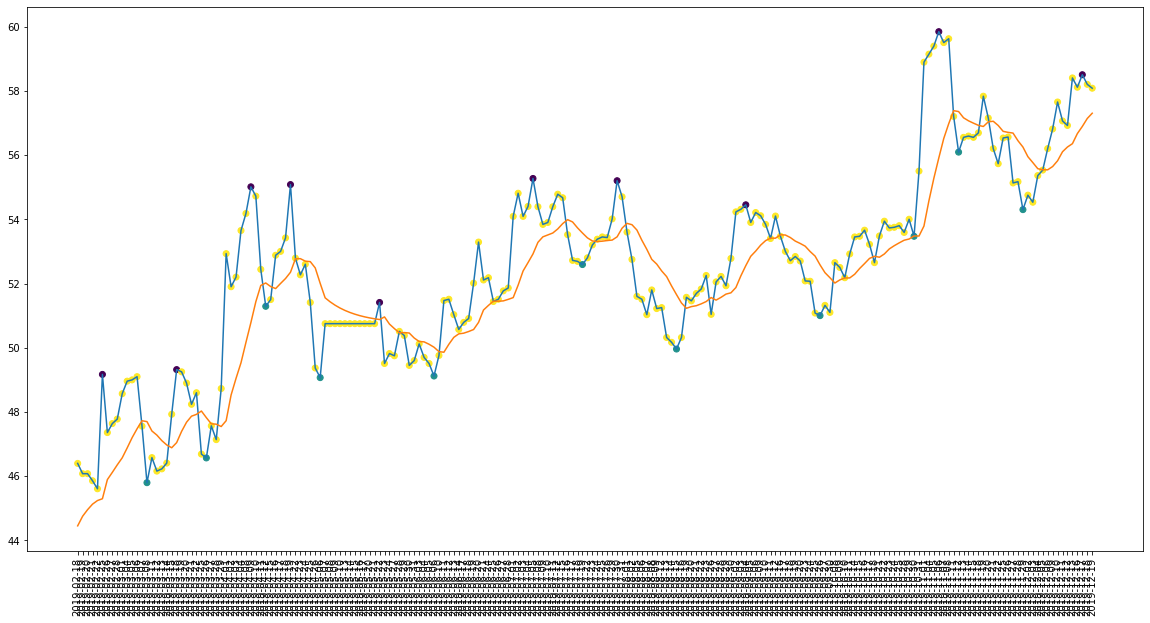

In [76]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [77]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 19
actual holds but predicted sell: 13
actual predicted holds: 154
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 30.0%
Percentage holds correct: 82.79569892473118%
actual buys: 11
actual sells: 10
actual holds: 186


In [78]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 54.54545454545455%
Percentage sells correct: 62.5%
Percentage holds correct: 80.95238095238095%


In [79]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $49.16999816894531
Shares owned at the moment: 202
Cash capital at the moment: $40.346435890198336


Stop Loss Activated!

Share price: $47.36000061035156
Shares owned at the moment: 0
Cash capital at the moment: $9580.758078842164


Share price: $47.63999938964844
Shares owned at the moment: 200
Cash capital at the moment: $26.5562012481696


Stop Loss Activated!

Share price: $45.79999923706055
Shares owned at the moment: 0
Cash capital at the moment: $9161.366049079896


Share price: $49.06999969482422
Shares owned at the moment: 186
Cash capital at the moment: $9.246800998687831


Price increase from previously bought: 9.927982313939342%
Share price: $54.09000015258789
Shares owned at the moment: 0
Cash capital at the moment: $10042.319794301986


Share price: $53.45000076293945
Shares owned at the moment: 187
Cash capital at the moment: $19.682988739965367


Stop Loss Activated!

Share price: $51.599998474121094
Shares owned at the moment: 0
Cash capital at the moment

In [80]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


### recession

In [81]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-16,58.400002,56.667715,-2.074657,1.246874e+09,2.0
2019-12-17,58.110001,56.889605,-8.091274,1.225225e+09,0.0
2019-12-18,58.500000,57.137358,-8.538913,1.250810e+09,2.0
2019-12-19,58.200001,57.300842,-19.572930,1.227161e+09,2.0
2019-12-20,58.080002,57.420713,-23.018822,1.213685e+09,2.0


In [82]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [83]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(208, 20, 4)

In [84]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [85]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2055 - accuracy: 0.7452 - mean_squared_error: 5.4703 - weighted_accuracy: 0.7452 - weighted_mean_squared_error: 5.4703
Test loss: 0.20546172559261322
Test accuracy: 0.745192289352417


In [86]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 169, 1: 16, 0: 23})

In [87]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [88]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-88-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-88-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-88-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,2,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,2,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,2,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,2,2


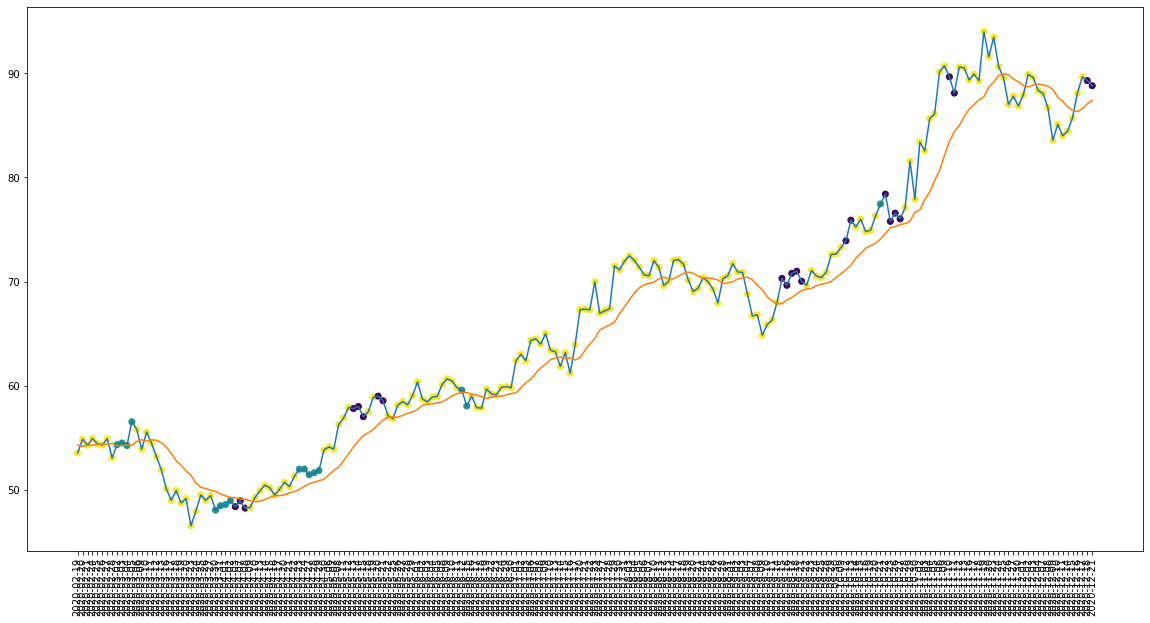

In [89]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

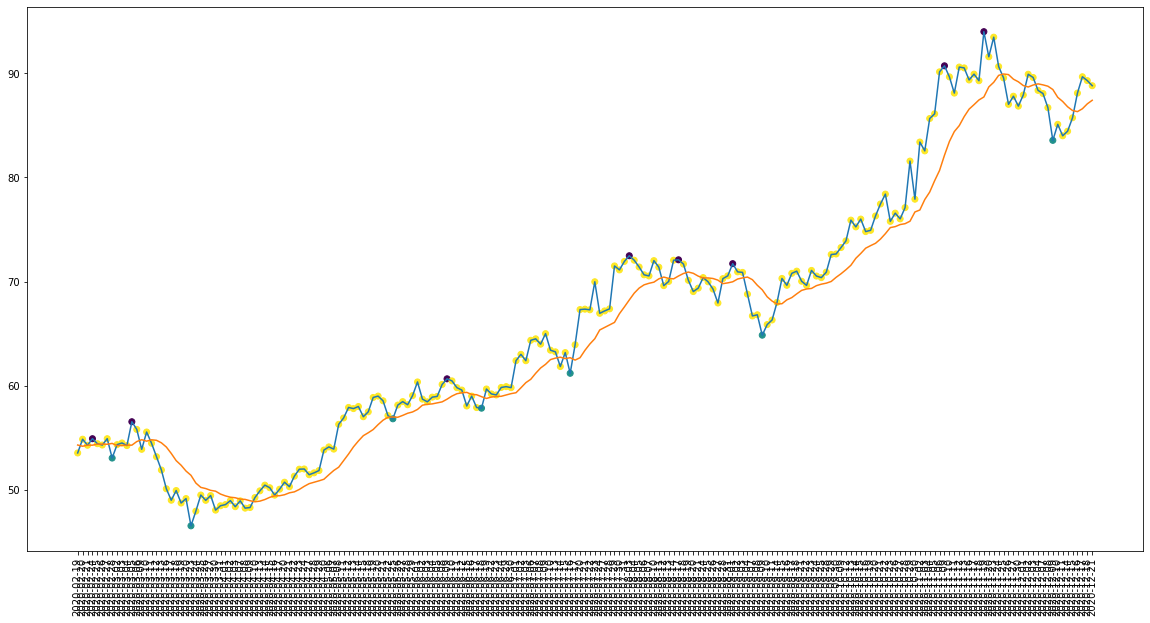

In [90]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [91]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 15
actual holds but predicted sell: 23
actual predicted holds: 155
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 80.31088082901555%
actual buys: 7
actual sells: 8
actual holds: 193


In [92]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 50.0%
Percentage sells correct: 52.17391304347826%
Percentage holds correct: 84.52380952380952%


In [93]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.34000015258789
Shares owned at the moment: 183
Cash capital at the moment: $28.43336699962674


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9500.014970467566


Share price: $48.04999923706055
Shares owned at the moment: 197
Cash capital at the moment: $8.13403367996034


Price increase from previously bought: 19.96146944458581%
Share price: $57.79999923706055
Shares owned at the moment: 0
Cash capital at the moment: $11363.42073379421


Share price: $59.58000183105469
Shares owned at the moment: 190
Cash capital at the moment: $12.089834937092746


Stop Loss Activated!

Share price: $57.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $10982.837374056811


Share price: $77.44999694824219
Shares owned at the moment: 141
Cash capital at the moment: $32.35656803798156


Price increase from previously bought: 15.447538243332959%
Share price: $89.66000366210938
Shares owned at the mom

In [94]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


## Walmart

In [95]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


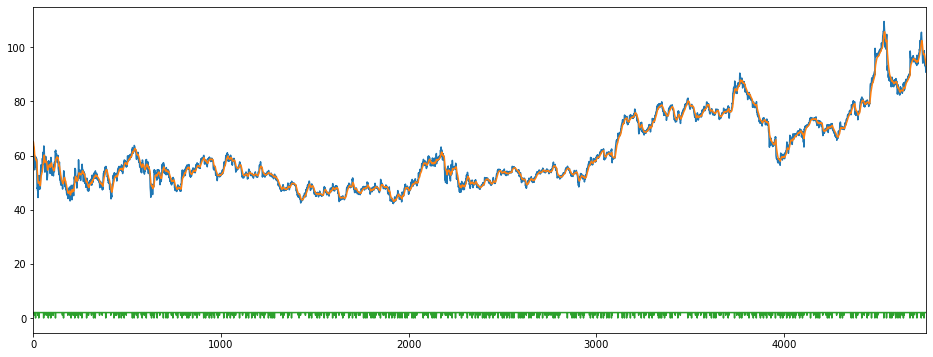

In [96]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [97]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [98]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [99]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
X.shape

(4740, 20, 4)

In [100]:
y = labels
y = np.array(y)

In [101]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [102]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [103]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [104]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [105]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2919 - accuracy: 0.5076 - mse: 0.4540 - weighted_accuracy: 0.3034 - weighted_mse: 0.5275 - val_loss: 0.2988 - val_accuracy: 0.0485 - val_mse: 0.3562 - val_weighted_accuracy: 0.0485 - val_weighted_mse: 0.3562
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2109 - accuracy: 0.4048 - mse: 0.7609 - weighted_accuracy: 0.4047 - weighted_mse: 0.7780 - val_loss: 0.2895 - val_accuracy: 0.0454 - val_mse: 0.3832 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3832
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1925 - accuracy: 0.2853 - mse: 1.0218 - weighted_accuracy: 0.4420 - weighted_mse: 1.0024 - val_loss: 0.2795 - val_accuracy: 0.0454 - val_mse: 0.4192 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.4192
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1849 - accuracy: 0.2969 - mse: 1.1368 - weighted_accuracy: 0.4683 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1407 - accuracy: 0.3916 - mse: 1.5888 - weighted_accuracy: 0.6952 - weighted_mse: 1.5078 - val_loss: 0.1877 - val_accuracy: 0.3797 - val_mse: 1.5802 - val_weighted_accuracy: 0.3797 - val_weighted_mse: 1.5802
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1409 - accuracy: 0.3819 - mse: 1.6034 - weighted_accuracy: 0.7063 - weighted_mse: 1.5172 - val_loss: 0.1808 - val_accuracy: 0.4209 - val_mse: 1.4864 - val_weighted_accuracy: 0.4209 - val_weighted_mse: 1.4864
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1402 - accuracy: 0.4214 - mse: 1.6038 - weighted_accuracy: 0.7028 - weighted_mse: 1.5186 - val_loss: 0.1886 - val_accuracy: 0.3787 - val_mse: 1.5806 - val_weighted_accuracy: 0.3787 - val_weighted_mse: 1.5806
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1386 - accuracy: 0.4082 - mse: 1.6317 - weighted_accuracy: 0.7194 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1185 - accuracy: 0.5435 - mse: 2.0507 - weighted_accuracy: 0.7836 - weighted_mse: 1.9963 - val_loss: 0.1798 - val_accuracy: 0.4895 - val_mse: 2.0573 - val_weighted_accuracy: 0.4895 - val_weighted_mse: 2.0573
Epoch 60/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1174 - accuracy: 0.5630 - mse: 2.0248 - weighted_accuracy: 0.7980 - weighted_mse: 1.9777 - val_loss: 0.1765 - val_accuracy: 0.4968 - val_mse: 2.1514 - val_weighted_accuracy: 0.4968 - val_weighted_mse: 2.1514
Epoch 61/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1170 - accuracy: 0.5496 - mse: 2.0924 - weighted_accuracy: 0.7985 - weighted_mse: 2.0468 - val_loss: 0.1888 - val_accuracy: 0.4610 - val_mse: 2.1142 - val_weighted_accuracy: 0.4610 - val_weighted_mse: 2.1142
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1155 - accuracy: 0.5791 - mse: 2.0633 - weighted_accuracy: 0.8057 - weig

Epoch 88/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0953 - accuracy: 0.6725 - mse: 2.6918 - weighted_accuracy: 0.8472 - weighted_mse: 2.6802 - val_loss: 0.2005 - val_accuracy: 0.5105 - val_mse: 2.7482 - val_weighted_accuracy: 0.5105 - val_weighted_mse: 2.7482
Epoch 89/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0957 - accuracy: 0.6772 - mse: 2.6739 - weighted_accuracy: 0.8491 - weighted_mse: 2.6823 - val_loss: 0.1727 - val_accuracy: 0.6044 - val_mse: 2.8342 - val_weighted_accuracy: 0.6044 - val_weighted_mse: 2.8342
Epoch 90/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0934 - accuracy: 0.6770 - mse: 2.6510 - weighted_accuracy: 0.8562 - weighted_mse: 2.6405 - val_loss: 0.1747 - val_accuracy: 0.5960 - val_mse: 2.8739 - val_weighted_accuracy: 0.5960 - val_weighted_mse: 2.8739
Epoch 91/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0938 - accuracy: 0.6922 - mse: 2.7154 - weighted_accuracy: 0.8636 - weig

Epoch 117/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0748 - accuracy: 0.7582 - mse: 3.5696 - weighted_accuracy: 0.8985 - weighted_mse: 3.5639 - val_loss: 0.2195 - val_accuracy: 0.5527 - val_mse: 3.6977 - val_weighted_accuracy: 0.5527 - val_weighted_mse: 3.6977
Epoch 118/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0766 - accuracy: 0.7521 - mse: 3.6432 - weighted_accuracy: 0.8944 - weighted_mse: 3.6265 - val_loss: 0.1914 - val_accuracy: 0.6013 - val_mse: 4.0684 - val_weighted_accuracy: 0.6013 - val_weighted_mse: 4.0684
Epoch 119/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0726 - accuracy: 0.7579 - mse: 3.6291 - weighted_accuracy: 0.9075 - weighted_mse: 3.6373 - val_loss: 0.1839 - val_accuracy: 0.6276 - val_mse: 3.8888 - val_weighted_accuracy: 0.6276 - val_weighted_mse: 3.8888
Epoch 120/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0711 - accuracy: 0.7756 - mse: 3.6781 - weighted_accuracy: 0.9085 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0567 - accuracy: 0.8333 - mse: 4.9627 - weighted_accuracy: 0.9315 - weighted_mse: 4.8065 - val_loss: 0.2008 - val_accuracy: 0.6857 - val_mse: 5.8089 - val_weighted_accuracy: 0.6857 - val_weighted_mse: 5.8089
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0564 - accuracy: 0.8352 - mse: 5.0104 - weighted_accuracy: 0.9359 - weighted_mse: 4.8602 - val_loss: 0.1886 - val_accuracy: 0.6962 - val_mse: 5.2659 - val_weighted_accuracy: 0.6962 - val_weighted_mse: 5.2659
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0577 - accuracy: 0.8199 - mse: 4.9823 - weighted_accuracy: 0.9230 - weighted_mse: 4.8437 - val_loss: 0.1866 - val_accuracy: 0.7025 - val_mse: 5.3505 - val_weighted_accuracy: 0.7025 - val_weighted_mse: 5.3505
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0551 - accuracy: 0.8394 - mse: 5.0376 - weighted_accuracy: 0.9356 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0436 - accuracy: 0.8747 - mse: 6.4613 - weighted_accuracy: 0.9540 - weighted_mse: 6.0372 - val_loss: 0.1949 - val_accuracy: 0.7500 - val_mse: 6.7618 - val_weighted_accuracy: 0.7500 - val_weighted_mse: 6.7618
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0441 - accuracy: 0.8787 - mse: 6.4743 - weighted_accuracy: 0.9518 - weighted_mse: 6.0686 - val_loss: 0.2239 - val_accuracy: 0.6835 - val_mse: 6.7061 - val_weighted_accuracy: 0.6835 - val_weighted_mse: 6.7061
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0453 - accuracy: 0.8745 - mse: 6.5941 - weighted_accuracy: 0.9503 - weighted_mse: 6.2016 - val_loss: 0.2181 - val_accuracy: 0.7004 - val_mse: 6.9381 - val_weighted_accuracy: 0.7004 - val_weighted_mse: 6.9381
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0442 - accuracy: 0.8710 - mse: 6.6278 - weighted_accuracy: 0.9454 - 

In [106]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2214864045381546
Test accuracy: 0.7900843620300293


In [107]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.3431847  -0.3079788  -0.58852273]
 [-3.0677962  -0.9268721   0.33553457]
 [-5.300344   -2.5820975   1.5220231 ]
 ...
 [-3.5364647  -4.3783665   2.423787  ]
 [-0.64276755 -4.1773796  -0.24927789]
 [-2.5363631   1.2813387  -2.2552793 ]]


Counter({1: 57, 2: 822, 0: 69})

In [108]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 861, 0: 44, 1: 43})

In [109]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 948
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 39
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 40
actual holds but predicted buy: 53
actual holds but predicted sell: 65
actual predicted holds: 743
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 86.29500580720092%
actual buys: 43
actual sells: 44
actual holds: 861


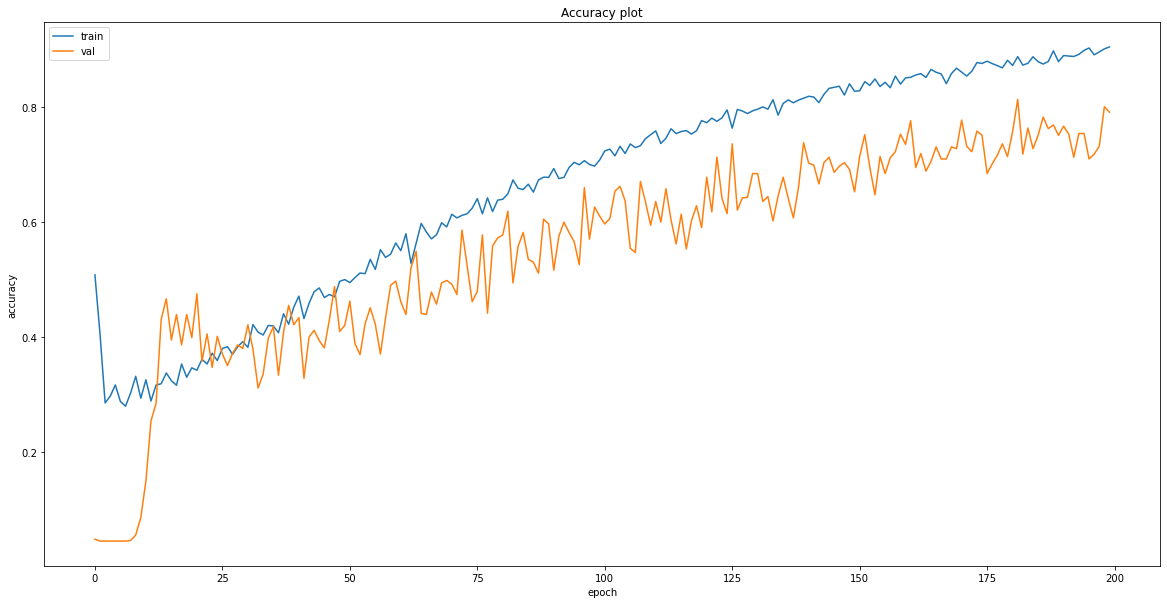

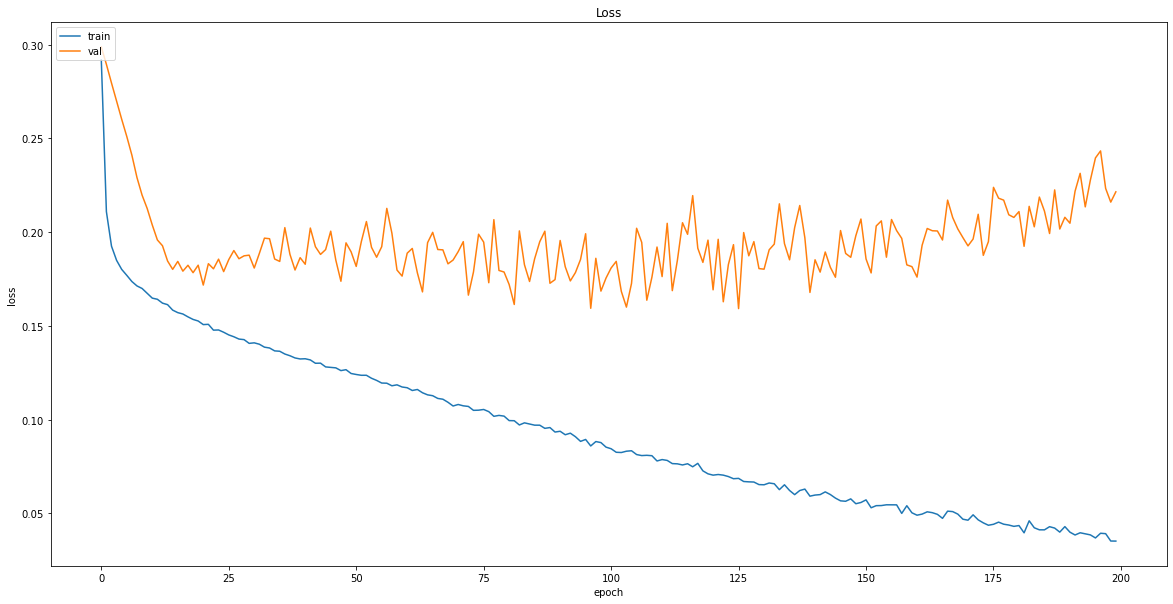

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [111]:
# Save model
model.save("models/{}".format('wmt_time_series_lstm_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/wmt_time_series_lstm_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [112]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-13,93.110001,95.261110,-89.379251,98530500.0,2.0
2018-12-14,92.959999,94.907093,-91.448238,90488200.0,2.0
2018-12-17,91.849998,94.436771,-96.508742,78994600.0,2.0
2018-12-18,90.769997,93.872652,-93.531353,69992800.0,2.0
2018-12-19,91.080002,93.443013,-90.243914,79599500.0,2.0


In [113]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(218, 20, 4)

In [114]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [115]:
model = tf.keras.models.load_model("models/wmt_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2444 - accuracy: 0.7752 - mean_squared_error: 11.3548 - weighted_accuracy: 0.7752 - weighted_mean_squared_error: 11.3548
Test loss: 0.24444067478179932
Test accuracy: 0.7752293348312378


In [116]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 177, 0: 31, 1: 10})

In [117]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [118]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-118-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-118-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-118-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,2,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,2,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


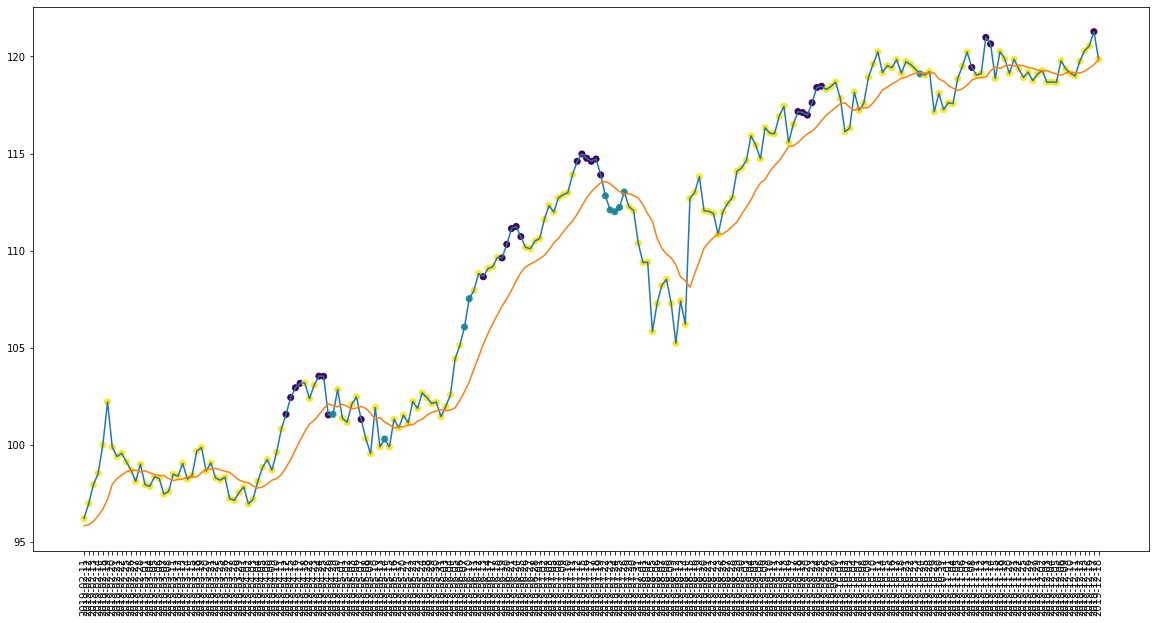

In [119]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

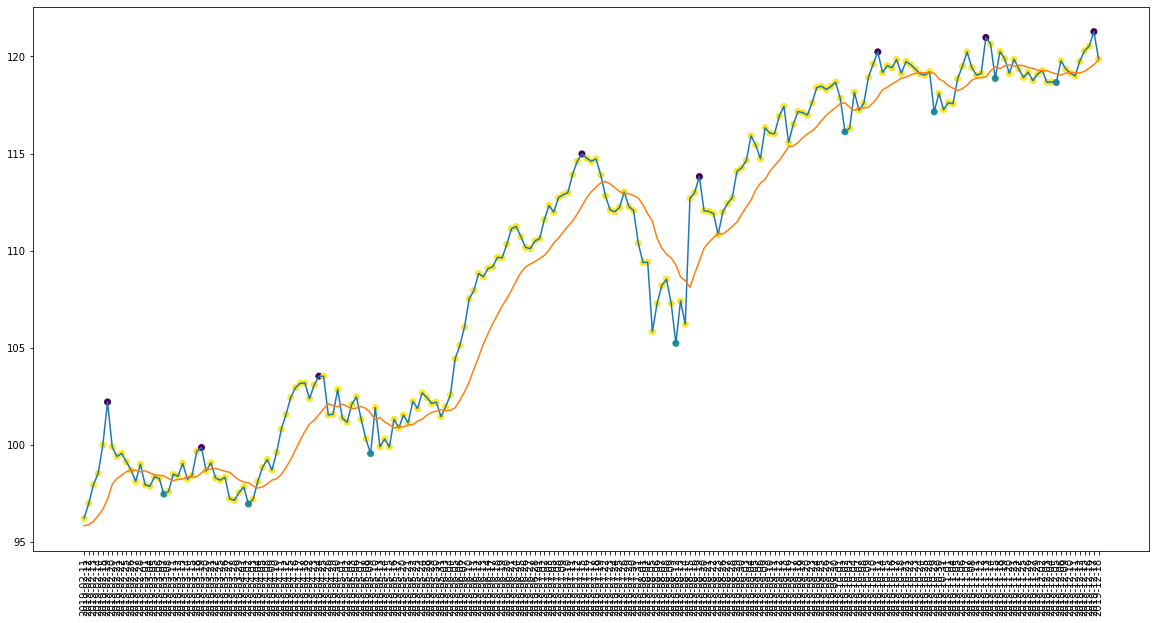

In [120]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [121]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 10
actual holds but predicted sell: 27
actual predicted holds: 165
Percentage buys correct: 0.0%
Percentage sells correct: 50.0%
Percentage holds correct: 81.68316831683168%
actual buys: 8
actual sells: 8
actual holds: 202


In [122]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 60.0%
Percentage sells correct: 66.66666666666667%
Percentage holds correct: 86.44067796610169%


In [123]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $101.55999755859376
Shares owned at the moment: 98
Cash capital at the moment: $19.749819915768967


Price increase from previously bought: 6.687707796983%
Share price: $108.6500015258789
Shares owned at the moment: 0
Cash capital at the moment: $10638.168794040677


Share price: $112.81999969482422
Shares owned at the moment: 94
Cash capital at the moment: $3.924852806088893


Stop Loss Activated!

Share price: $109.37999725341795
Shares owned at the moment: 0
Cash capital at the moment: $10257.369865337367


Share price: $119.0999984741211
Shares owned at the moment: 85
Cash capital at the moment: $106.03037039374794




Capital at the end of test period: $10266.11314713096
profit gained: 2.6611314713096%


In [124]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


### Recession

In [125]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-13,119.760002,119.241902,-18.750000,211183700.0,2.0
2019-12-16,120.290001,119.403148,-11.145518,216550000.0,2.0
2019-12-17,120.540001,119.578049,-20.610623,221900700.0,0.0
2019-12-18,121.279999,119.839887,-9.813044,226476500.0,2.0
2019-12-19,119.860001,119.842981,-42.990581,221373500.0,2.0


In [126]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(219, 20, 4)

In [127]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [128]:
model = tf.keras.models.load_model("models/wmt_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1572 - accuracy: 0.8676 - mean_squared_error: 10.5358 - weighted_accuracy: 0.8676 - weighted_mean_squared_error: 10.5358
Test loss: 0.15717680752277374
Test accuracy: 0.8675799369812012


In [129]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 206, 1: 9, 0: 4})

In [130]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [131]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-131-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-131-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-131-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


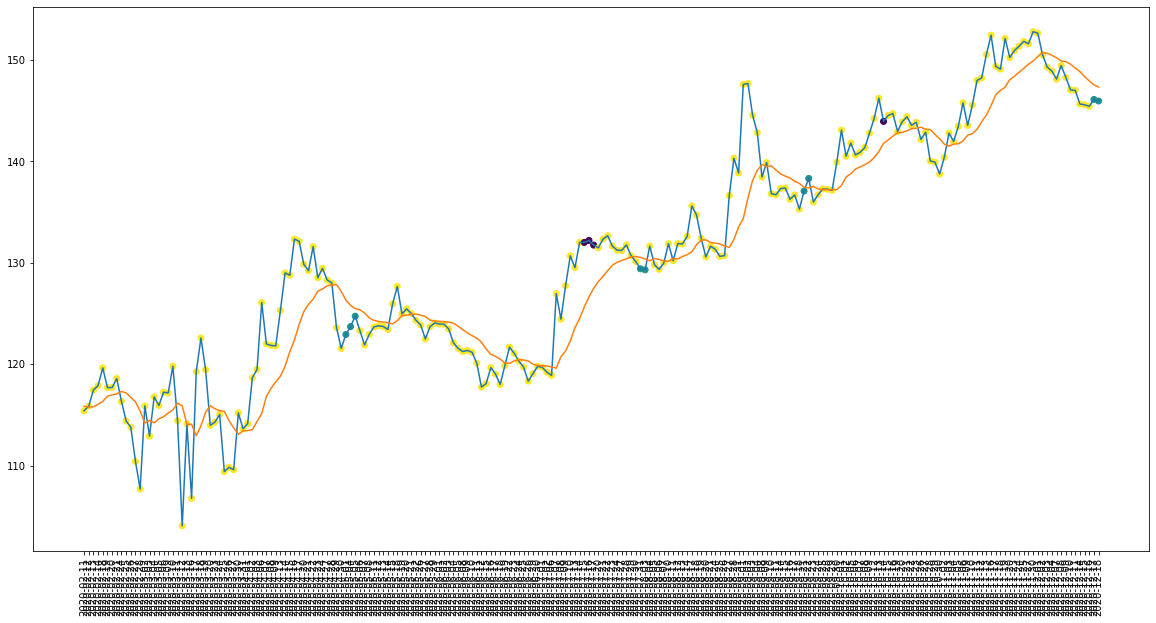

In [132]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

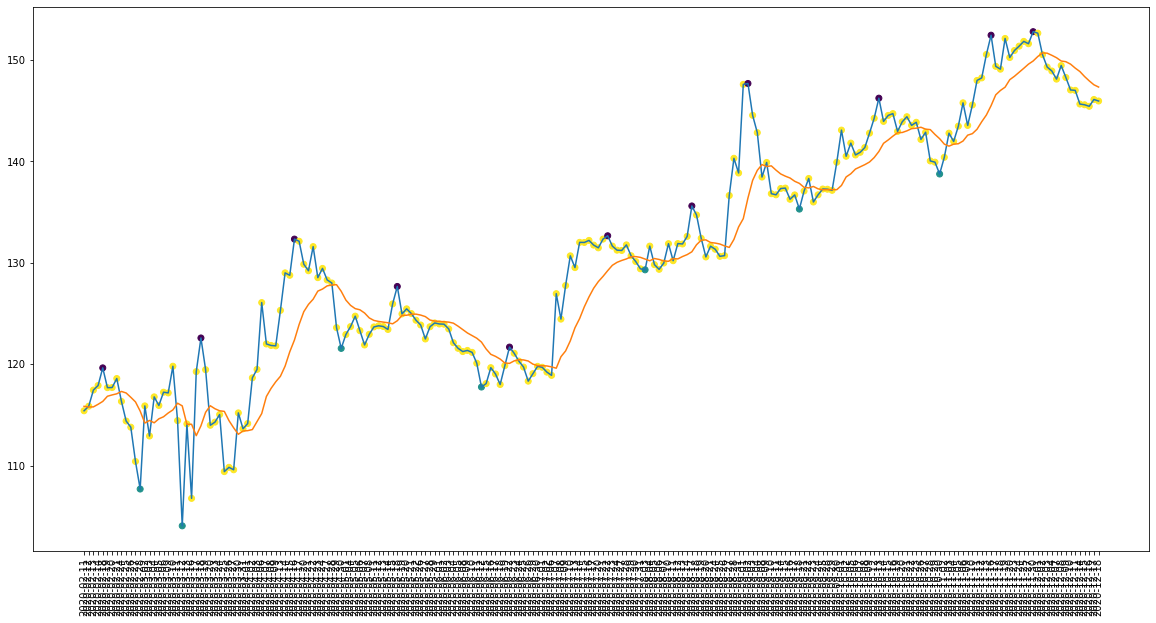

In [133]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [134]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 8
actual holds but predicted sell: 4
actual predicted holds: 189
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 0.0%
Percentage holds correct: 94.02985074626865%
actual buys: 7
actual sells: 11
actual holds: 201


In [135]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 50.0%
Percentage holds correct: 85.85365853658537%


In [136]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $122.91999816894531
Shares owned at the moment: 81
Cash capital at the moment: $16.099718723296974


Stop Loss Activated!

Share price: $117.73999786376952
Shares owned at the moment: 0
Cash capital at the moment: $9526.812961164473


Share price: $129.39999389648438
Shares owned at the moment: 73
Cash capital at the moment: $54.63635794639413


Price increase from previously bought: 10.93142176691253%
Share price: $143.94000244140625
Shares owned at the moment: 0
Cash capital at the moment: $10533.360580678938


Share price: $146.10000610351562
Shares owned at the moment: 71
Cash capital at the moment: $131.73412113761697




Capital at the end of test period: $10465.687167558668
profit gained: 4.656871675586681%


In [137]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


## Fresh Del Monte Produce Inc

In [138]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


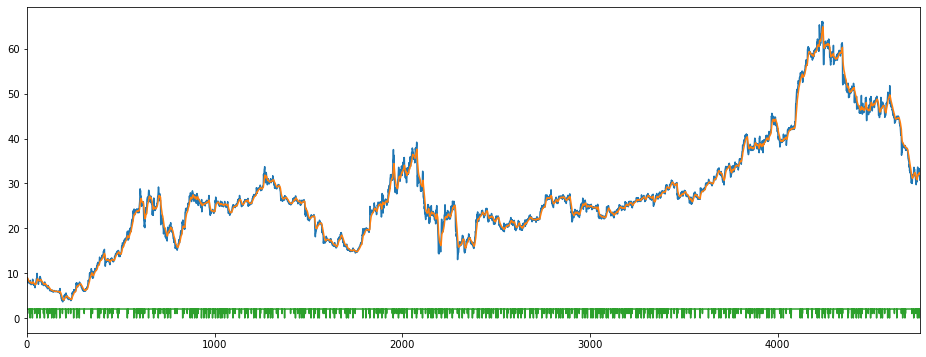

In [139]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [140]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [141]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(4740, 20, 4)

In [142]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [143]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [144]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [145]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [146]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2896 - accuracy: 0.5034 - mse: 0.4599 - weighted_accuracy: 0.3112 - weighted_mse: 0.5298 - val_loss: 0.2989 - val_accuracy: 0.0464 - val_mse: 0.3560 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3560
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2119 - accuracy: 0.3871 - mse: 0.7657 - weighted_accuracy: 0.4246 - weighted_mse: 0.7762 - val_loss: 0.2894 - val_accuracy: 0.0464 - val_mse: 0.3841 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3841
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1931 - accuracy: 0.3004 - mse: 1.0058 - weighted_accuracy: 0.4766 - weighted_mse: 0.9841 - val_loss: 0.2787 - val_accuracy: 0.0464 - val_mse: 0.4226 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4226
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1854 - accuracy: 0.2845 - mse: 1.1417 - weighted_accuracy: 0.4908 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1404 - accuracy: 0.4509 - mse: 1.5305 - weighted_accuracy: 0.7131 - weighted_mse: 1.4424 - val_loss: 0.1777 - val_accuracy: 0.4768 - val_mse: 1.3966 - val_weighted_accuracy: 0.4768 - val_weighted_mse: 1.3966
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1395 - accuracy: 0.4562 - mse: 1.5395 - weighted_accuracy: 0.7132 - weighted_mse: 1.4465 - val_loss: 0.1862 - val_accuracy: 0.4198 - val_mse: 1.5523 - val_weighted_accuracy: 0.4198 - val_weighted_mse: 1.5523
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1382 - accuracy: 0.4821 - mse: 1.5479 - weighted_accuracy: 0.7190 - weighted_mse: 1.4689 - val_loss: 0.1914 - val_accuracy: 0.4093 - val_mse: 1.5238 - val_weighted_accuracy: 0.4093 - val_weighted_mse: 1.5238
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1377 - accuracy: 0.4644 - mse: 1.5850 - weighted_accuracy: 0.7182 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1102 - accuracy: 0.5986 - mse: 2.0453 - weighted_accuracy: 0.8272 - weighted_mse: 1.9702 - val_loss: 0.1711 - val_accuracy: 0.5738 - val_mse: 2.1737 - val_weighted_accuracy: 0.5738 - val_weighted_mse: 2.1737
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1089 - accuracy: 0.6472 - mse: 2.0354 - weighted_accuracy: 0.8450 - weighted_mse: 1.9757 - val_loss: 0.1887 - val_accuracy: 0.5264 - val_mse: 2.1699 - val_weighted_accuracy: 0.5264 - val_weighted_mse: 2.1699
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1094 - accuracy: 0.6253 - mse: 2.0751 - weighted_accuracy: 0.8296 - weighted_mse: 2.0115 - val_loss: 0.1691 - val_accuracy: 0.5907 - val_mse: 2.2225 - val_weighted_accuracy: 0.5907 - val_weighted_mse: 2.2225
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1077 - accuracy: 0.6313 - mse: 2.1340 - weighted_accuracy: 0.8284 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0863 - accuracy: 0.7376 - mse: 2.8043 - weighted_accuracy: 0.8728 - weighted_mse: 2.7573 - val_loss: 0.1800 - val_accuracy: 0.6371 - val_mse: 3.1160 - val_weighted_accuracy: 0.6371 - val_weighted_mse: 3.1160
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0864 - accuracy: 0.7249 - mse: 2.8145 - weighted_accuracy: 0.8827 - weighted_mse: 2.7469 - val_loss: 0.1893 - val_accuracy: 0.5728 - val_mse: 2.8842 - val_weighted_accuracy: 0.5728 - val_weighted_mse: 2.8842
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0834 - accuracy: 0.7318 - mse: 2.7911 - weighted_accuracy: 0.8833 - weighted_mse: 2.7276 - val_loss: 0.1836 - val_accuracy: 0.6487 - val_mse: 3.2574 - val_weighted_accuracy: 0.6487 - val_weighted_mse: 3.2574
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0842 - accuracy: 0.7368 - mse: 2.8878 - weighted_accuracy: 0.8870 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0688 - accuracy: 0.7959 - mse: 3.7975 - weighted_accuracy: 0.9160 - weighted_mse: 3.6628 - val_loss: 0.2034 - val_accuracy: 0.5949 - val_mse: 3.9334 - val_weighted_accuracy: 0.5949 - val_weighted_mse: 3.9334
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0687 - accuracy: 0.7880 - mse: 3.8493 - weighted_accuracy: 0.9076 - weighted_mse: 3.7028 - val_loss: 0.1753 - val_accuracy: 0.6857 - val_mse: 4.0829 - val_weighted_accuracy: 0.6857 - val_weighted_mse: 4.0829
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0667 - accuracy: 0.8030 - mse: 3.8797 - weighted_accuracy: 0.9186 - weighted_mse: 3.7519 - val_loss: 0.1806 - val_accuracy: 0.6899 - val_mse: 4.0838 - val_weighted_accuracy: 0.6899 - val_weighted_mse: 4.0838
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0654 - accuracy: 0.8035 - mse: 3.9011 - weighted_accuracy: 0.9206 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0516 - accuracy: 0.8452 - mse: 5.2052 - weighted_accuracy: 0.9395 - weighted_mse: 4.9068 - val_loss: 0.2144 - val_accuracy: 0.6751 - val_mse: 5.3779 - val_weighted_accuracy: 0.6751 - val_weighted_mse: 5.3779
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0498 - accuracy: 0.8616 - mse: 5.2869 - weighted_accuracy: 0.9473 - weighted_mse: 4.9274 - val_loss: 0.2061 - val_accuracy: 0.6941 - val_mse: 5.3088 - val_weighted_accuracy: 0.6941 - val_weighted_mse: 5.3088
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0492 - accuracy: 0.8563 - mse: 5.3826 - weighted_accuracy: 0.9436 - weighted_mse: 4.9725 - val_loss: 0.2050 - val_accuracy: 0.7405 - val_mse: 6.3717 - val_weighted_accuracy: 0.7405 - val_weighted_mse: 6.3717
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0507 - accuracy: 0.8597 - mse: 5.3916 - weighted_accuracy: 0.9430 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0406 - accuracy: 0.8842 - mse: 6.9370 - weighted_accuracy: 0.9557 - weighted_mse: 6.3095 - val_loss: 0.2025 - val_accuracy: 0.7700 - val_mse: 7.2758 - val_weighted_accuracy: 0.7700 - val_weighted_mse: 7.2758
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0397 - accuracy: 0.8890 - mse: 7.0011 - weighted_accuracy: 0.9574 - weighted_mse: 6.3589 - val_loss: 0.2204 - val_accuracy: 0.7795 - val_mse: 8.0161 - val_weighted_accuracy: 0.7795 - val_weighted_mse: 8.0161
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0402 - accuracy: 0.8861 - mse: 7.0093 - weighted_accuracy: 0.9528 - weighted_mse: 6.4131 - val_loss: 0.2256 - val_accuracy: 0.7278 - val_mse: 7.4407 - val_weighted_accuracy: 0.7278 - val_weighted_mse: 7.4407
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0405 - accuracy: 0.8877 - mse: 7.2572 - weighted_accuracy: 0.9533 - 

In [147]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.24278225004673004
Test accuracy: 0.7911392450332642


In [148]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.6520004  -5.226565    1.8521779 ]
 [-3.590596   -3.5408897   2.2309902 ]
 [ 0.72051126 -6.0477543  -0.33868104]
 ...
 [-0.75671583 -3.5749402   0.1611436 ]
 [-0.188345   -4.6131845  -0.2005417 ]
 [-3.8345702  -4.178092    3.6807785 ]]


Counter({2: 826, 0: 54, 1: 68})

In [149]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 861, 0: 43, 1: 44})

In [150]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 948
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 41
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 40
actual holds but predicted buy: 64
actual holds but predicted sell: 52
actual predicted holds: 745
Percentage buys correct: 6.818181818181818%
Percentage sells correct: 4.651162790697675%
Percentage holds correct: 86.52729384436701%
actual buys: 44
actual sells: 43
actual holds: 861


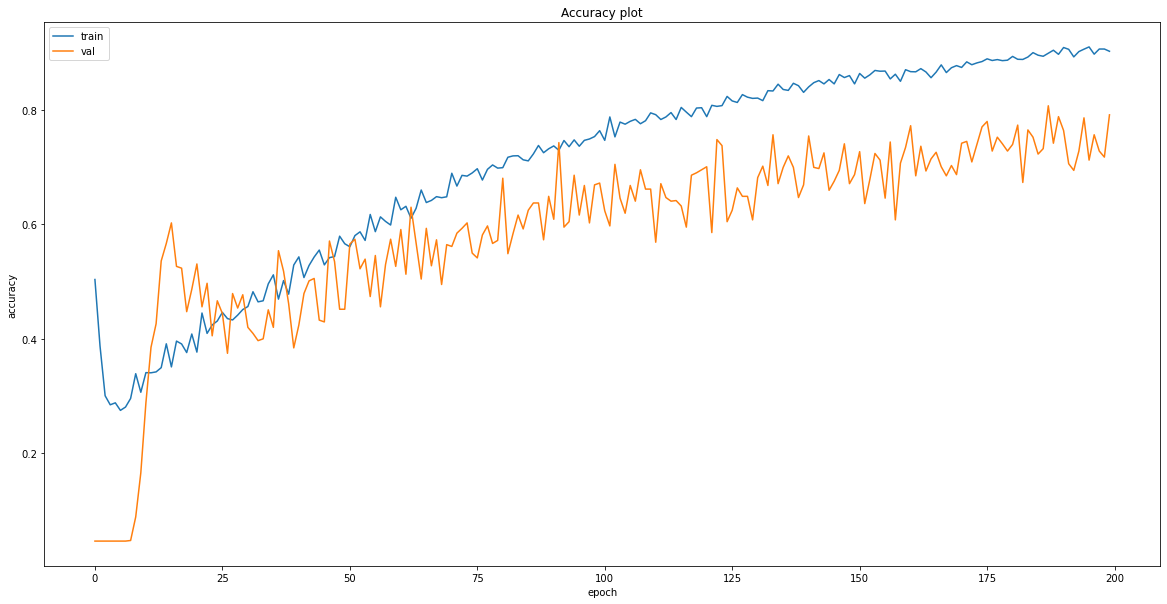

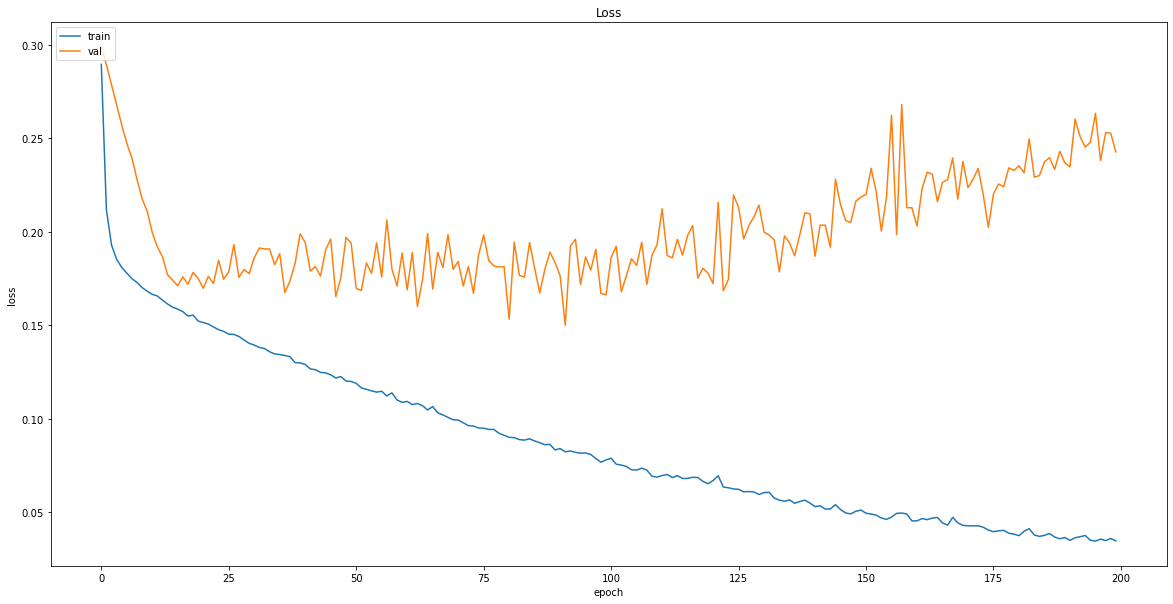

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [152]:
# Save model
model.save("models/{}".format('FDP_time_series_lstm_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/FDP_time_series_lstm_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [153]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-13,33.090000,32.210365,-29.500008,41799100.0,0.0
2018-12-14,33.310001,32.379540,-23.999977,42032900.0,2.0
2018-12-17,32.500000,32.398072,-44.923863,41904100.0,2.0
2018-12-18,32.150002,32.359908,-55.064902,41601100.0,2.0
2018-12-19,30.770000,32.115306,-94.085991,41369900.0,2.0


In [154]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(218, 20, 4)

In [155]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [156]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2240 - accuracy: 0.8119 - mean_squared_error: 9.6294 - weighted_accuracy: 0.8119 - weighted_mean_squared_error: 9.6294
Test loss: 0.22396709024906158
Test accuracy: 0.8119266033172607


In [157]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 197, 0: 4, 1: 17})

In [158]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [159]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-159-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-159-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-159-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,2,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,2,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,2,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,2,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


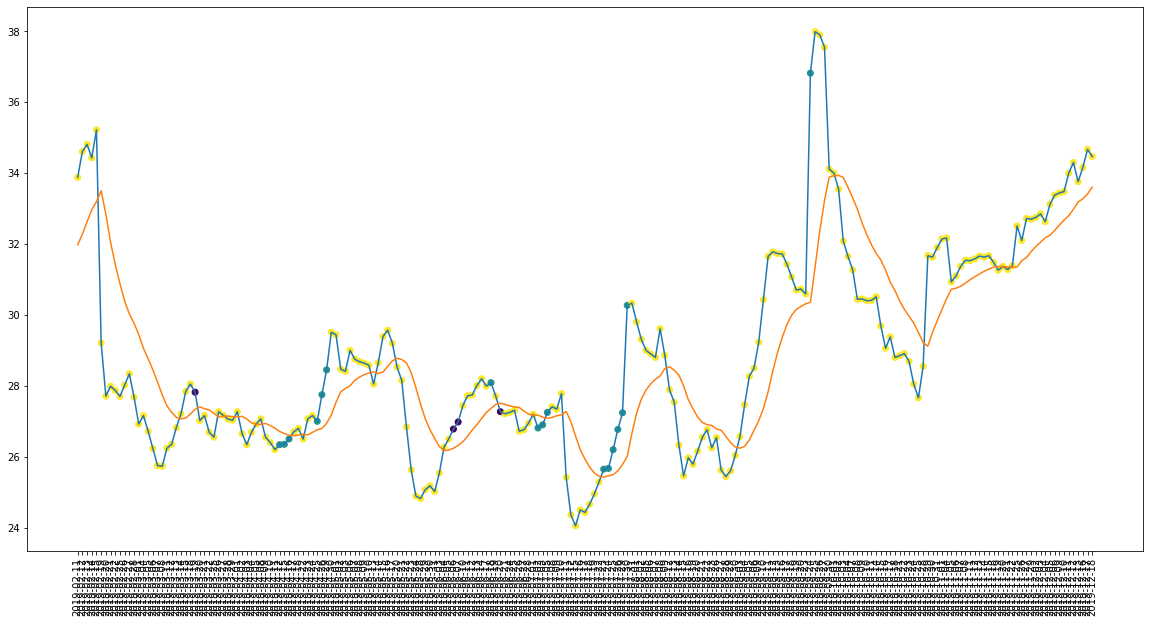

In [160]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

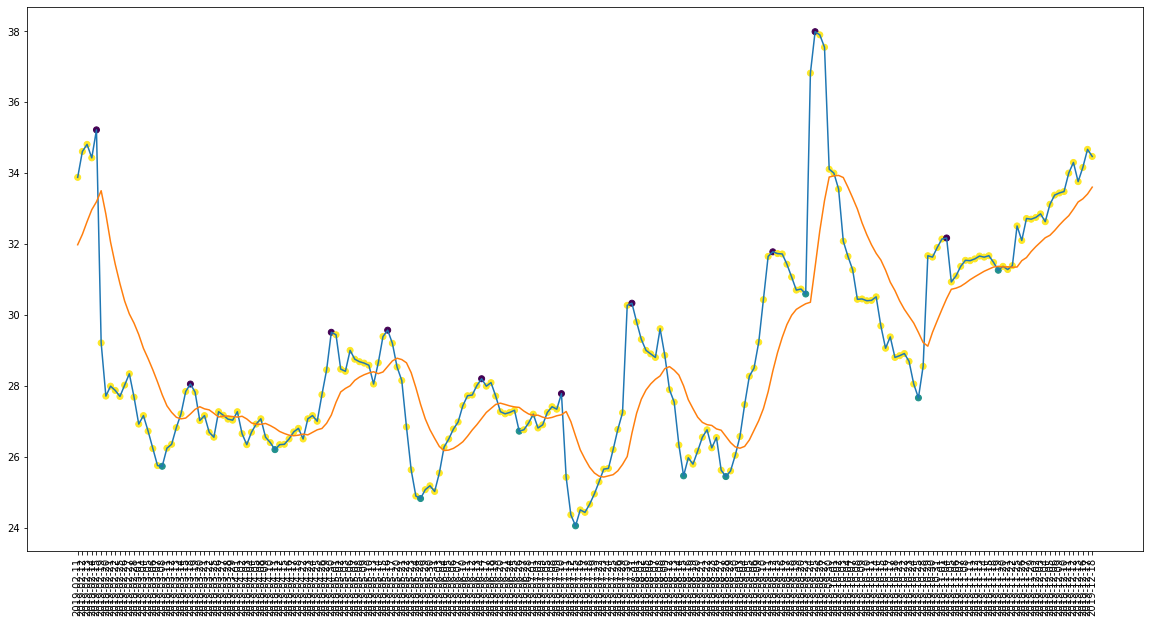

In [161]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [162]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 17
actual holds but predicted sell: 4
actual predicted holds: 177
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 89.39393939393939%
actual buys: 10
actual sells: 10
actual holds: 198


In [163]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 29.41176470588235%
Percentage sells correct: 25.0%
Percentage holds correct: 82.14285714285714%


In [164]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $26.34000015258789
Shares owned at the moment: 378
Cash capital at the moment: $16.099512163162217


Stop Loss Activated!

Share price: $24.88999938964844
Shares owned at the moment: 0
Cash capital at the moment: $9398.646127084734


Share price: $28.09000015258789
Shares owned at the moment: 333
Cash capital at the moment: $18.952658633234023


Stop Loss Activated!

Share price: $27.270000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9074.890308149339


Share price: $26.809999465942386
Shares owned at the moment: 337
Cash capital at the moment: $15.074321121692265


Stop Loss Activated!

Share price: $25.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8558.056361762046


Share price: $25.649999618530273
Shares owned at the moment: 332
Cash capital at the moment: $18.838038758276525




Capital at the end of test period: $11431.407332917212
profit gained: 14.314073329172118%


In [165]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


### recession

In [166]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-13,34.299999,33.185402,-7.909676,-4911100.0,2.0
2019-12-16,33.759998,33.273801,-23.163935,-5027000.0,2.0
2019-12-17,34.160000,33.410139,-15.789538,-4850100.0,2.0
2019-12-18,34.669998,33.603964,-3.968344,-4647200.0,2.0
2019-12-19,34.470001,33.737200,-18.420973,-4830200.0,2.0


In [167]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(219, 20, 4)

In [168]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [169]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1811 - accuracy: 0.7808 - mean_squared_error: 9.0361 - weighted_accuracy: 0.7808 - weighted_mean_squared_error: 9.0361
Test loss: 0.18109406530857086
Test accuracy: 0.7808219194412231


In [170]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 186, 0: 15, 1: 18})

In [171]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [172]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-172-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-172-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-172-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,2,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,2,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,2,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,2,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,2,2


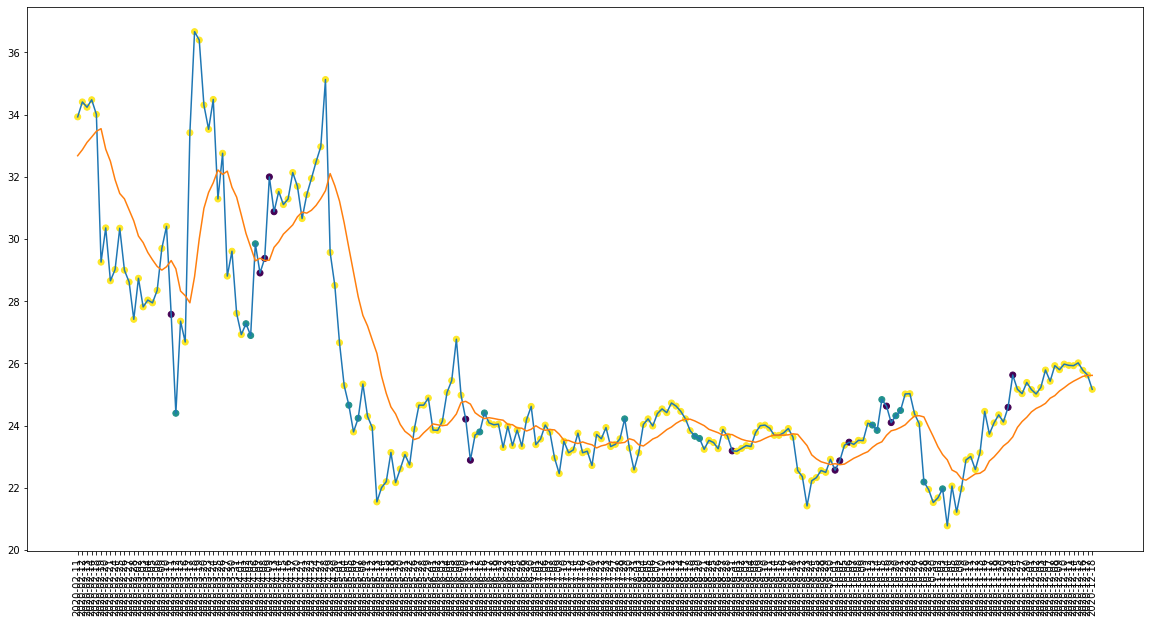

In [173]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

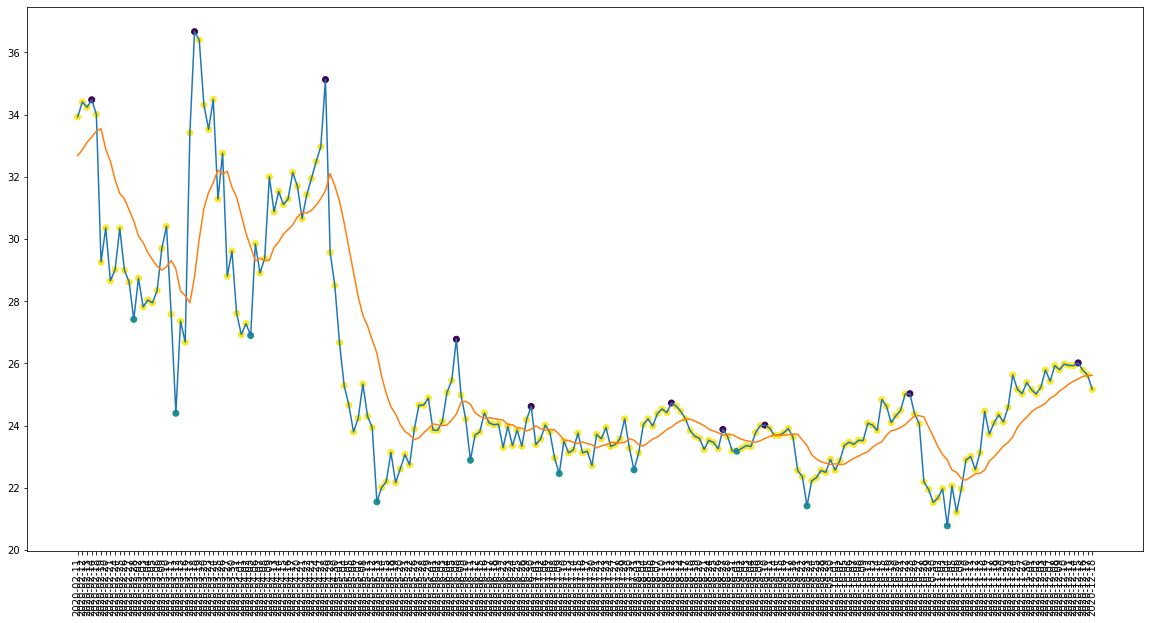

In [174]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [175]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 14
actual predicted holds: 169
Percentage buys correct: 20.0%
Percentage sells correct: 0.0%
Percentage holds correct: 84.92462311557789%
actual buys: 10
actual sells: 10
actual holds: 199


In [176]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 26.666666666666668%
Percentage holds correct: 83.78378378378379%


In [177]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $24.399999618530273
Shares owned at the moment: 408
Cash capital at the moment: $17.42335606765664


Price increase from previously bought: 18.15867143793586%
Share price: $28.90999984741211
Shares owned at the moment: 0
Cash capital at the moment: $11780.266273983001


Share price: $24.65999984741211
Shares owned at the moment: 476
Cash capital at the moment: $9.826406814574511


Stop Loss Activated!

Share price: $23.79999923706055
Shares owned at the moment: 0
Cash capital at the moment: $11307.471844654085


Share price: $24.239999771118164
Shares owned at the moment: 465
Cash capital at the moment: $4.87505137682092


Stop Loss Activated!

Share price: $21.549999237060547
Shares owned at the moment: 0
Cash capital at the moment: $9998.067635085583


Share price: $23.79999923706055
Shares owned at the moment: 418
Cash capital at the moment: $22.309854871271455


Stop Loss Activated!

Share price: $22.959999084472656
Shares owned at the moment: 0
Cash capital at the mom

In [178]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%
